# Instalando dependências

In [89]:
!pip install --upgrade pip setuptools wheel

In [1]:
!pip install scikit-learn -qqq

In [2]:
!pip install category_encoders -qqq

In [3]:
!pip install shap -qqq

In [31]:
!pip install seaborn -qqq

In [1]:
# !pip install forestci

# Importando dependências

In [2]:
from dataclasses import dataclass

import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit, GroupKFold

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import KBinsDiscretizer


sklearn.set_config(transform_output="pandas")

pd.options.display.max_columns = None

In [96]:

def predict_interval(X, pipeline, quantile = [0.25, 0.5, 0.75]):
    all_tree_predictions = pd.DataFrame([tree.predict(X.values) for tree in pipeline.named_steps['regressor'].estimators_])
    response = all_tree_predictions.quantile(quantile).T
    response.columns = ["lower", "median", "upper"]
    return response


In [3]:


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")
        return X[self.columns].copy()


class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column  # Nome da coluna de data

    def fit(self, X, y=None):
        # Nenhum ajuste necessário
        return self

    def transform(self, X):
        X = X.copy()
        # Converte a coluna de data para datetime se não estiver
        if not np.issubdtype(X[self.date_column].dtype, np.datetime64):
            X[self.date_column] = pd.to_datetime(X[self.date_column], errors='coerce')
        
        # Verifica se houve erro na conversão
        if X[self.date_column].isnull().any():
            raise ValueError("Há valores nulos ou formatos inválidos na coluna de data após a conversão.")
        
        # Extrai ano, mês, dia e número da semana
        X['year'] = X[self.date_column].dt.year
        X['month'] = X[self.date_column].dt.month
        X['day'] = X[self.date_column].dt.day
        X['week_number'] = X[self.date_column].dt.isocalendar().week

        # Remove a coluna original de data (opcional)
        X = X.drop(columns=[self.date_column])

        return X

class AmenitiesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, amenities_column='amenities_list', relevant_amenities=None):
        self.amenities_column = amenities_column
        self.relevant_amenities = relevant_amenities

    def fit(self, X, y=None):
        # Nenhum ajuste necessário, mas você pode implementar se quiser
        return self

    def transform(self, X):
        import numpy as np
        import pandas as pd
        import ast

        X = X.copy()
        relevant_amenities = np.array(self.relevant_amenities)

        def crate_amenities_encoding(x):
            if not x or pd.isna(x):
                return np.zeros(len(relevant_amenities), dtype=int)
            try:
                estate_amenities = ast.literal_eval(x)
                return np.isin(relevant_amenities, estate_amenities).astype(int)
            except (ValueError, SyntaxError):
                return np.zeros(len(relevant_amenities), dtype=int)

        amenities_encoded_list = X[self.amenities_column].apply(crate_amenities_encoding).tolist()
        amenities_encoded = pd.DataFrame(amenities_encoded_list, columns=relevant_amenities)

        # Concatenar as novas colunas ao DataFrame original
        X.reset_index(drop=True, inplace=True)
        amenities_encoded.reset_index(drop=True, inplace=True)
        X = pd.concat([X, amenities_encoded], axis=1)

        # Remover a coluna original de amenidades, se desejar
        X.drop(columns=[self.amenities_column], inplace=True)

        return X


In [4]:


class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_bins=5, encode='ordinal', strategy='quantile'):
        self.columns = columns
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.discretizer_ = None

    def fit(self, X, y=None):
        # Verificar se todas as colunas existem no DataFrame
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")

        # Ajustar o discretizador apenas com as colunas selecionadas
        self.discretizer_ = KBinsDiscretizer(n_bins=self.n_bins, encode=self.encode, strategy=self.strategy)
        self.discretizer_.fit(X[self.columns])

        return self

    def transform(self, X):
        X = X.copy()
        # Verificar novamente se todas as colunas estão presentes
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")

        # Aplicar o discretizador às colunas
        transformed_values = self.discretizer_.transform(X[self.columns])
        
        # Se o encode for 'ordinal', a saída é um array 2D com os buckets, substituímos diretamente
        # Se for 'onehot' ou 'onehot-dense', teremos mais colunas do que inicialmente
        # Nesse caso, é necessário criar novas colunas. Aqui vamos lidar apenas com 'ordinal' para simplificar.
        if self.encode == 'ordinal':
            X[self.columns] = transformed_values
        else:
            # Caso onehot, criamos um DataFrame separado e concatenamos
            # Os nomes das colunas podem ser gerados a partir das colunas originais + índices dos bins
            bin_column_names = []
            for col_idx, col_name in enumerate(self.columns):
                for bin_idx in range(self.n_bins):
                    bin_column_names.append(f"{col_name}_bin_{bin_idx}")
            
            onehot_df = pd.DataFrame(transformed_values, columns=bin_column_names, index=X.index)
            # Remover as colunas originais e concatenar as novas
            X.drop(columns=self.columns, inplace=True)
            X = pd.concat([X, onehot_df], axis=1)

        return X


# Preparo da base de dados

In [5]:
df = pd.read_csv("/app/pc_zap_scrapper/datasets/imoveis_2024_12_01.csv")
df['estate_id'] = df['estate_id'].astype(str)
df = df.drop(columns=["price_m2"])
df = df.loc[df["type"].isin(["Casa", "Apartamento", "Lote"])]

df = df.sample(len(df))

df

/tmp/ipykernel_82/3020523043.py:1: DtypeWarning: Columns (1,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/app/pc_zap_scrapper/datasets/imoveis_2024_12_01.csv")


,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
6436,32bd5724-19b9-491e-b8e5-f0f693c99706,2503300361,venda,2022-01-15,NaN,/imovel/venda-casa-3-quartos-com-piscina-jardi...,Casa,NaN,Casa no Residencial VOGO VILLA VITÓRIA- no bai...,NaN,Jardim Vitoria V,Poços de Caldas,MG,-21.802387,-46.571022,180.0,3.0,1.0,2.0,"['BARBECUE_GRILL', 'INTERCOM', 'POOL']",590000.0,0.0,0.0
77923,5c5c0b1a-3e0d-4308-951f-039d16ca694b,2576835753,venda,2022-10-10,NaN,/imovel/venda-terreno-lote-condominio-jardim-n...,Lote,NaN,"Lote em condomínio fechado, 20,03 metros de fr...",NaN,Jardim Novo Mundo,Poços de Caldas,MG,-21.790887,-46.588854,630.0,0.0,0.0,0.0,['GATED_COMMUNITY'],630000.0,300.0,0.0
81547,c7811939-4939-48f3-aa45-8cb8ee2765a1,2556607415,venda,2022-10-16,NaN,/imovel/venda-casa-3-quartos-com-copa-jardim-n...,Casa,NaN,"OPORTUNIDADE! <br><br>CASA ESPAÇOSA, ENSOLARAD...",NaN,Jardim Novo Mundo,Poços de Caldas,MG,-21.790887,-46.588854,268.0,3.0,2.0,3.0,"['COPA', 'SERVICE_AREA']",600000.0,0.0,0.0
72869,968e73c6-8a02-40a8-a63c-e8155cfffaa8,2574122674,venda,2022-09-26,NaN,/imovel/venda-casa-de-condominio-3-quartos-com...,Apartamento,NaN,Casa no Bairro residencial Morumbi <br><br>03 ...,NaN,Residencial Morumbi,Poços de Caldas,MG,-21.807490,-46.579703,105.0,3.0,3.0,2.0,"['BALCONY', 'CABLE_TV', 'INTERNET_ACCESS', 'MO...",450000.0,100.0,0.0
79832,2960b64f-de4e-4080-b7aa-35b763ab10d9,2568092856,venda,2022-10-16,NaN,/imovel/venda-casa-3-quartos-com-cozinha-jardi...,Casa,NaN,Casa à venda no bairro Jardim São Paulo em Poç...,NaN,Jardim São Paulo,Poços de Caldas,MG,-21.795189,-46.549774,207.0,3.0,2.0,3.0,"['KITCHEN', 'INTERCOM', 'HOME_OFFICE', 'SERVIC...",735000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51147,8a888ae9-0ac2-4143-8b72-ccfe5a2e3f3a,2503299431,venda,2022-06-12,NaN,/imovel/venda-apartamento-3-quartos-jardim-dos...,Apartamento,NaN,Apartamento no bairro Jardim dos Estados- Poço...,NaN,Jardim dos Estados,Poços de Caldas,MG,-21.783975,-46.552999,167.0,3.0,2.0,1.0,"['GATED_COMMUNITY', 'ELEVATOR', 'INTERCOM']",500000.0,0.0,0.0
1394,3c6a745e-38c1-4c86-9b70-227f30cd9365,2568096547,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,Casa com 3 quartos à venda,NaN,Jardim das Hortênsias,Poços de Caldas,MG,-21.804587,-46.542271,234.0,3.0,1.0,2.0,"['Churrasqueira', 'Cozinha', 'Quintal']",950000.0,0.0,1.0
52873,dbf73a7b-9acc-4632-ba8b-c6afec19e561,2539033095,venda,2022-07-02,NaN,/imovel/venda-casa-3-quartos-campo-das-antas-p...,Casa,NaN,Casa no Campo das Antas com aproximadamente 12...,NaN,Campo das Antas,Poços de Caldas,MG,-21.807018,-46.607488,126.0,3.0,2.0,2.0,[''],499000.0,0.0,725.0
49346,7a369b36-55a3-48ec-87ea-4e7a620d4e87,2559688657,venda,2022-06-12,NaN,/imovel/venda-casa-3-quartos-com-cozinha-jardi...,Casa,NaN,"Casa em localização privilegiada, sendo 128 m²...",NaN,Jardim Amaryllis,Poços de Caldas,MG,-21.805017,-46.542837,128.0,3.0,2.0,2.0,"['KITCHEN', 'INTERCOM', 'CABLE_TV', 'SERVICE_A...",620000.0,0.0,0.0


In [6]:
def grouped_train_test_split(df: pd.DataFrame, groups: pd.Series, test_size: float, random_state: float | None = None):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)    
    train_idx, test_idx = next(gss.split(df, groups=groups))
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)
    return df_train, df_test
    

@dataclass
class Fold:
    data_train: pd.DataFrame
    data_val: pd.DataFrame

    def __init__(self, df, train_index, val_index):
        self.data_train = df.iloc[train_index]
        self.data_val = df.iloc[val_index]


In [7]:
N_FOLDS = 5

# Não podemos usar o index do dataframe. Esse é o index no imóvel,
# que pode aparecer mais de uma vez no dataframe
INDEX_COLUMN = 'estate_id'

TARGET_COLUMN = 'price'

df = df.loc[~df[TARGET_COLUMN].isna()]



df_train, df_test = grouped_train_test_split(df, groups=df[INDEX_COLUMN], test_size=0.2, random_state=42)


folds = [Fold(df_train, train_index, val_index) for train_index, val_index in GroupKFold(n_splits=N_FOLDS).split(df_train, groups=df_train[INDEX_COLUMN])]

# Visão Geral

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'amenities_list',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]

relevant_amenities = [
    'FIREPLACE',
    'POOL',
    'DINNER_ROOM',
    'HOME_OFFICE',
    'BACKYARD',
    'INTERCOM',
    'ELEVATOR',
    'LAUNDRY',
    'CLOSET',
    'GATED_COMMUNITY',
    'KITCHEN',
    'GOURMET_BALCONY',
    'SERVICE_AREA',
    'BARBECUE_GRILL',
    'BALCONY',
    'ALARM_SYSTEM',
    'SPORTS_COURT',
    'DEPOSIT',
    'NUMBER_OF_FLOORS',
    'GARDEN',
    'HEATING',
    'SAUNA',
    'Condomínio fechado',
    'PARTY_HALL',
    'GOURMET_SPACE',
    'CABLE_TV',
    'COPA',
    'FURNISHED',
    'MOUNTAIN_VIEW',
    'BUILTIN_WARDROBE',
]



pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('amenities_encoder', AmenitiesEncoder(
        amenities_column='amenities_list',
        relevant_amenities=relevant_amenities
    )),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', MinMaxScaler()),
])


In [7]:
%%time

from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

metrics = []

models = {
    "catboost": CatBoostRegressor(random_state=42, verbose=0),
    "random_forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "linear_regression": LinearRegression(),
    "decision_tree": DecisionTreeRegressor(),
    "hist_gradient_boosting": HistGradientBoostingRegressor(),
    "xgboost": XGBRegressor(random_state=42),
    "lightgbm": LGBMRegressor(random_state=42),
    "adaboost": AdaBoostRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
}

for label, model in tqdm(models.items(), desc="Model"):
    fold_metrics = []
    for fold in tqdm(folds, desc="Fold", leave=False):
        data_train = fold.data_train
        data_val = fold.data_val

        X_train = data_train.drop(columns=TARGET_COLUMN)
        X_val = data_val.drop(columns=TARGET_COLUMN)

        y_train = data_train[TARGET_COLUMN]
        y_val = data_val[TARGET_COLUMN]

        pipeline.fit(X_train, y_train)

        X_train_processed = pipeline.transform(X_train)
        X_val_processed = pipeline.transform(X_val)

        model.fit(X_train_processed, y_train)

        y_train_predicted = model.predict(X_train_processed)
        y_val_predicted = model.predict(X_val_processed)

        fold_metrics.append(
            {
                "mae_train": mean_absolute_error(y_train, y_train_predicted),
                "mae_val": mean_absolute_error(y_val, y_val_predicted),
                "r2_train": r2_score(y_train, y_train_predicted),
                "r2_val": r2_score(y_val, y_val_predicted),
            }
        )

    metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()
    metrics_agg.update({"label": label})
    print(metrics_agg)
    metrics.append(metrics_agg)


Model:  11%|█         | 1/9 [00:58<07:50, 58.77s/it][A

{'mae_train': 76514.07771127317, 'mae_val': 141785.1664550685, 'r2_train': 0.9676198090479783, 'r2_val': 0.5247696876078425, 'label': 'catboost'}



Model:  22%|██▏       | 2/9 [03:43<14:07, 121.03s/it]A

{'mae_train': 9779.506297633088, 'mae_val': 113321.17353390937, 'r2_train': 0.9776739133347953, 'r2_val': 0.653711727627695, 'label': 'random_forest'}



Model:  33%|███▎      | 3/9 [04:16<08:04, 80.80s/it] A

{'mae_train': 203472.99063021885, 'mae_val': 212183.83305506044, 'r2_train': 0.4706096878204109, 'r2_val': 0.13967829499040998, 'label': 'linear_regression'}



Model:  44%|████▍     | 4/9 [04:50<05:12, 62.45s/it][A

{'mae_train': 926.7550664247741, 'mae_val': 146433.06187933646, 'r2_train': 0.9998854812402811, 'r2_val': 0.42199449166155134, 'label': 'decision_tree'}



Model:  56%|█████▌    | 5/9 [05:28<03:34, 53.74s/it][A

{'mae_train': 107896.95463124305, 'mae_val': 153044.51340600452, 'r2_train': 0.8081806030212946, 'r2_val': 0.5090675447245898, 'label': 'hist_gradient_boosting'}



Model:  67%|██████▋   | 6/9 [06:17<02:35, 51.84s/it][A

{'mae_train': 72036.5438103909, 'mae_val': 145122.03794434015, 'r2_train': 0.9429124482719171, 'r2_val': 0.36943930339913084, 'label': 'xgboost'}



Fold:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 44
[LightGBM] [Info] Start training from score 568712.182558



Fold:  20%|██        | 1/5 [00:09<00:39,  9.89s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 44
[LightGBM] [Info] Start training from score 567670.294104



Fold:  40%|████      | 2/5 [00:19<00:29,  9.80s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 44
[LightGBM] [Info] Start training from score 582543.420346



Fold:  60%|██████    | 3/5 [00:30<00:20, 10.07s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 44
[LightGBM] [Info] Start training from score 565033.424218



Fold:  80%|████████  | 4/5 [00:39<00:10, 10.01s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 61724, number of used features: 44
[LightGBM] [Info] Start training from score 578090.005314



Model:  78%|███████▊  | 7/9 [07:06<01:42, 51.09s/it][A

{'mae_train': 102185.25265237926, 'mae_val': 146025.88595642563, 'r2_train': 0.8363372118294408, 'r2_val': 0.5782815230662806, 'label': 'lightgbm'}



Model:  89%|████████▉ | 8/9 [08:18<00:57, 57.73s/it][A

{'mae_train': 847911.450761542, 'mae_val': 874414.6995249618, 'r2_train': -1.0748415214181695, 'r2_val': -2.778889235893298, 'label': 'adaboost'}



Model: 100%|██████████| 9/9 [09:30<00:00, 63.39s/it][A

{'mae_train': 139409.3649809317, 'mae_val': 164955.58160362858, 'r2_train': 0.8274909149174563, 'r2_val': 0.6117088848687502, 'label': 'gradient_boosting'}
CPU times: user 14min 29s, sys: 35.1 s, total: 15min 4s
Wall time: 9min 30s


In [10]:
pd.DataFrame(metrics)[["label", "mae_train", "r2_train", "mae_val", "r2_val"]]

,label,mae_train,r2_train,mae_val,r2_val
0,catboost,76514.077711,0.967620,141785.166455,0.524770
1,random_forest,9779.506298,0.977674,113321.173534,0.653712
2,linear_regression,203472.990630,0.470610,212183.833055,0.139678
3,decision_tree,926.755066,0.999885,146433.061879,0.421994
4,hist_gradient_boosting,107896.954631,0.808181,153044.513406,0.509068
5,xgboost,72036.543810,0.942912,145122.037944,0.369439
6,lightgbm,102185.252652,0.836337,146025.885956,0.578282
7,adaboost,847911.450762,-1.074842,874414.699525,-2.778889
8,gradient_boosting,139409.364981,0.827491,164955.581604,0.611709


# Without Amenities

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]



pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', MinMaxScaler()),
])


In [12]:
%%time

from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

metrics = []

models = {
    "catboost": CatBoostRegressor(random_state=42, verbose=0),
    "random_forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "linear_regression": LinearRegression(),
    "decision_tree": DecisionTreeRegressor(),
    "hist_gradient_boosting": HistGradientBoostingRegressor(),
    "xgboost": XGBRegressor(random_state=42),
    "lightgbm": LGBMRegressor(random_state=42),
    "adaboost": AdaBoostRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
}

for label, model in tqdm(models.items(), desc="Model"):
    fold_metrics = []
    for fold in tqdm(folds, desc="Fold", leave=False):
        data_train = fold.data_train
        data_val = fold.data_val

        X_train = data_train.drop(columns=TARGET_COLUMN)
        X_val = data_val.drop(columns=TARGET_COLUMN)

        y_train = data_train[TARGET_COLUMN]
        y_val = data_val[TARGET_COLUMN]

        pipeline.fit(X_train, y_train)

        X_train_processed = pipeline.transform(X_train)
        X_val_processed = pipeline.transform(X_val)

        model.fit(X_train_processed, y_train)

        y_train_predicted = model.predict(X_train_processed)
        y_val_predicted = model.predict(X_val_processed)

        fold_metrics.append(
            {
                "mae_train": mean_absolute_error(y_train, y_train_predicted),
                "mae_val": mean_absolute_error(y_val, y_val_predicted),
                "r2_train": r2_score(y_train, y_train_predicted),
                "r2_val": r2_score(y_val, y_val_predicted),
            }
        )

    metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()
    metrics_agg.update({"label": label})
    print(metrics_agg)
    metrics.append(metrics_agg)


Model:  11%|█         | 1/9 [00:25<03:20, 25.00s/it][A

{'mae_train': 80540.56801816696, 'mae_val': 141743.82792249418, 'r2_train': 0.9655596561137308, 'r2_val': 0.524823856253911, 'label': 'catboost'}



Model:  22%|██▏       | 2/9 [02:38<10:20, 88.62s/it][A

{'mae_train': 11430.649441393263, 'mae_val': 115056.39707467004, 'r2_train': 0.9770814106458925, 'r2_val': 0.6487315129009288, 'label': 'random_forest'}



Model:  33%|███▎      | 3/9 [02:42<05:00, 50.11s/it][A

{'mae_train': 211269.18968906306, 'mae_val': 219252.20283902631, 'r2_train': 0.46425324762616704, 'r2_val': -0.11315678668614951, 'label': 'linear_regression'}



Model:  44%|████▍     | 4/9 [02:48<02:44, 32.80s/it][A

{'mae_train': 2041.3669137175202, 'mae_val': 139533.06116551586, 'r2_train': 0.9997729263100057, 'r2_val': 0.4614706431890709, 'label': 'decision_tree'}



Model:  56%|█████▌    | 5/9 [02:55<01:34, 23.51s/it][A

{'mae_train': 114911.86802033198, 'mae_val': 156774.93997664127, 'r2_train': 0.7840371939838582, 'r2_val': 0.512272999254791, 'label': 'hist_gradient_boosting'}



Model:  67%|██████▋   | 6/9 [03:48<01:40, 33.49s/it][A

{'mae_train': 75597.18554358484, 'mae_val': 146254.64671450347, 'r2_train': 0.940746744825462, 'r2_val': 0.33327634508036164, 'label': 'xgboost'}



Fold:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 14
[LightGBM] [Info] Start training from score 568712.182558



Fold:  20%|██        | 1/5 [00:01<00:04,  1.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 14
[LightGBM] [Info] Start training from score 567670.294104



Fold:  40%|████      | 2/5 [00:02<00:02,  1.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 14
[LightGBM] [Info] Start training from score 582543.420346



Fold:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 61723, number of used features: 14
[LightGBM] [Info] Start training from score 565033.424218



Fold:  80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 61724, number of used features: 14
[LightGBM] [Info] Start training from score 578090.005314



Model:  78%|███████▊  | 7/9 [03:53<00:48, 24.09s/it][A

{'mae_train': 105811.45741075328, 'mae_val': 146403.7690807543, 'r2_train': 0.8337639856991327, 'r2_val': 0.582071040021132, 'label': 'lightgbm'}



Model:  89%|████████▉ | 8/9 [04:12<00:22, 22.53s/it][A

{'mae_train': 908302.3218709426, 'mae_val': 930614.8626979089, 'r2_train': -1.4130673793977846, 'r2_val': -2.6541625033684597, 'label': 'adaboost'}



Model: 100%|██████████| 9/9 [04:44<00:00, 31.63s/it][A

{'mae_train': 141602.8791087633, 'mae_val': 168468.55277698959, 'r2_train': 0.8350081610909654, 'r2_val': 0.48040223943694793, 'label': 'gradient_boosting'}
CPU times: user 15min 10s, sys: 33.6 s, total: 15min 44s
Wall time: 4min 44s


In [13]:
pd.DataFrame(metrics)[["label", "mae_train", "r2_train", "mae_val", "r2_val"]]

,label,mae_train,r2_train,mae_val,r2_val
0,catboost,80540.568018,0.965560,141743.827922,0.524824
1,random_forest,11430.649441,0.977081,115056.397075,0.648732
2,linear_regression,211269.189689,0.464253,219252.202839,-0.113157
3,decision_tree,2041.366914,0.999773,139533.061166,0.461471
4,hist_gradient_boosting,114911.868020,0.784037,156774.939977,0.512273
5,xgboost,75597.185544,0.940747,146254.646715,0.333276
6,lightgbm,105811.457411,0.833764,146403.769081,0.582071
7,adaboost,908302.321871,-1.413067,930614.862698,-2.654163
8,gradient_boosting,141602.879109,0.835008,168468.552777,0.480402


# Random Forest

In [10]:
!pip install duecredit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 3.4 MB/s eta 0:00:00a 0:00:01


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder, TargetEncoder, SumEncoder, QuantileEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from forestci import random_forest_error

### Experimento 1

In [104]:
%%time

selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]

categorical_columns = [
    "type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]

numerical_columns = [
    "latitude",
    "longitude",
    "floor_size",
    "condominium",
    "iptu",

]

# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = {}

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),  # MAE=94k
    # ('imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),
    # ('imputation', KNNImputer(n_neighbors=5)),
    # ('imputation', IterativeImputer(random_state=42)),
    # ('discretizer', Discretizer(columns=numerical_columns, n_bins=5, encode='ordinal', strategy='kmeans')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, **best_params))
])


################ OTIMIZACAO
# fold_metrics = []

# for fold in tqdm(folds, desc="Fold", leave=False):
#     data_train = fold.data_train
#     data_val = fold.data_val

#     X_train = data_train.drop(columns=TARGET_COLUMN)
#     X_val = data_val.drop(columns=TARGET_COLUMN)

#     y_train = data_train[TARGET_COLUMN]
#     y_val = data_val[TARGET_COLUMN]

#     pipeline.fit(X_train, y_train)


#     y_train_predicted = pipeline.predict(X_train)
#     y_val_predicted = pipeline.predict(X_val)

#     fold_metrics.append(
#         {
#             "mae_train": mean_absolute_error(y_train, y_train_predicted),
#             "mae_val": mean_absolute_error(y_val, y_val_predicted),
#             "r2_train": r2_score(y_train, y_train_predicted),
#             "r2_val": r2_score(y_val, y_val_predicted),
#         }
#     )

# metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()

# print(metrics_agg)


X_train = df_train.drop(columns=TARGET_COLUMN)
X_test = df_test.drop(columns=TARGET_COLUMN)

y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict(X_train)
y_test_predicted = pipeline.predict(X_test)

print(
    {
        "mae_train": mean_absolute_error(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(y_test, y_test_predicted),
        "r2_train": r2_score(y_train, y_train_predicted),
        "r2_val": r2_score(y_test, y_test_predicted),
    }
)

X_test_transf = preprocessing_pipeline.transform(X_test)
test_confidence_interval = predict_interval(X_test_transf, pipeline)

print(
    "Estimates with median:",
    {
        "mae_val": mean_absolute_error(y_test, test_confidence_interval["median"]),
        "r2_val": r2_score(y_test, test_confidence_interval["median"]),
    }
)

{'mae_train': 26860.04303445058, 'mae_val': 96993.20650517428, 'r2_train': 0.9198647404478227, 'r2_val': 0.8953830615676973}
Estimates with median: {'mae_val': 86580.5820161664, 'r2_val': 0.9136334223823855}
CPU times: user 1min 2s, sys: 79.2 ms, total: 1min 2s
Wall time: 1min 2s


In [143]:
bairro = 'Dom Bosco'

latlong_map = neighbor.to_dict(orient="index")
latitude = latlong_map.get(bairro.lower(), {}).get("latitude", None)
longitude = latlong_map.get(bairro.lower(), {}).get("longitude", None)

values = {
    'search_date': '2024-07-10',
    'type': 'Apartamento',
    'neighbor': bairro,
    'latitude': latitude,
    'longitude': longitude,
    'floor_size': 100.0,
    'number_of_rooms': 3.0,
    'number_of_bathrooms': 3.0,
    'number_of_parking_spaces': 2.0,
    'condominium': None,
    'iptu': None,
}

preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
regressor = pipeline.steps[-1][1]

# y_pred = pipeline.predict()
# y_pred

X_transf = preprocessing_pipeline.transform(pd.DataFrame([values]))

conf_interval = predict_interval(X_transf, pipeline)

conf_interval

,lower,median,upper
0,360000.0,430000.0,490000.0


In [136]:
latitude

-21.802998

In [129]:
bairro = 'Jardim dos Estados'

neighbor = pd.read_parquet("/app/pc_zap_scrapper/datasets/external/neighbor_latlong.parquet").set_index("neighborhood")

latlong_map = neighbor.to_dict(orient="index")



-21.7839753

{'latitude': -21.7839753, 'longitude': -46.5529987}

In [123]:
neighbor.to_dict(orient="tight")

{'index': ['residencial summer ville',
  'santa angela',
  'jardim das azaleias',
  'jardim ipe',
  'jardim esperanca',
  'sao benedito',
  'village sao luiz',
  'jardim quisisana',
  'jardim elvira dias',
  'jardim bandeirantes',
  'jardim vitoria',
  'vila rica',
  'jardim cascatinha',
  'jardim das hortensias',
  'vila togni',
  'residencial paineiras',
  'parque vivaldi leite ribeiro',
  'jardim centenario',
  'jardim carolina',
  'jardim dos estados',
  'centro',
  'parque pinheiros',
  'parque primavera',
  'caio junqueira',
  'parque san carlo',
  'jardim amaryllis',
  'jardim dos manacas',
  'residencial greenville',
  'estancia sao jose',
  'jardim formosa',
  'jardim sao paulo',
  'jardim country club',
  'jardim doutor ottoni',
  'residencial veredas',
  'vila nova',
  'residencial morumbi',
  'estancia pocos de caldas',
  'jardim europa',
  'jardim do contorno',
  'campo das antas',
  'jardim vitoria v',
  'conjunto habitacional pedro afonso junqueira',
  'dos funcionarios'

In [80]:






y_pred = regressor.predict(X_transf)

print(f"y_pred = {y_pred}")



y_pred = [605010.]


,0.15865,0.50000,0.84135
0,500000.0,620000.0,680000.0


Estimates with median: {'mae_val': 86580.5820161664, 'r2_val': 0.9136334223823855}


In [87]:
y_median_predict = test_confidence_interval[0.50000]

{'mae_val': 86580.5820161664, 'r2_val': 0.9136334223823855}


In [89]:
y_test_predicted

array([ 534429.93,  606159.97,  174375.  , ..., 1600000.  ,  623700.  ,
        269300.  ])

In [71]:
import numpy as np
import pandas as pd



all_tree_predictions = pd.DataFrame([tree.predict(X_test_transf.values) for tree in pipeline.named_steps['regressor'].estimators_]).T

# # Média das predições (já equivalente ao predict normal do random forest)
# mean_prediction = np.mean(all_tree_predictions)

# # Desvio padrão das predições
# std_prediction = np.std(all_tree_predictions)

# # Intervalo de confiança de 1-sigma
# lower_bound = mean_prediction - std_prediction
# upper_bound = mean_prediction + std_prediction

# print("Predição média:", mean_prediction)
# print("Intervalo de confiança 1σ: [", lower_bound, ",", upper_bound, "]")


In [75]:
all_tree_predictions.quantile([0.15865, 0.5, 0.84135], axis=1).T

,0.15865,0.50000,0.84135
0,4.653175e+05,530000.0,615000.00
1,4.411902e+05,594999.5,800000.00
2,1.550000e+05,170000.0,200000.00
3,2.500000e+05,270000.0,282642.85
4,2.100000e+05,210000.0,250000.00
...,...,...,...
19418,2.970635e+05,315000.0,315000.00
19419,2.582280e+05,350000.0,450000.00
19420,1.600000e+06,1600000.0,1600000.00
19421,6.200000e+05,620000.0,620000.00


In [64]:
all_tree_predictions

array([580000., 380000., 500000., 650000., 310000., 380000., 580000.,
       615000., 580000., 500000., 380000., 500000., 530000., 580000.,
       500000., 500000., 700000., 529999., 500000., 500000., 480000.,
       530000., 610000., 615000., 700000., 500000., 615000., 615000.,
       530000., 530000., 615000., 529999., 580000., 599000., 529999.,
       500000., 615000., 529999., 530000., 530000., 380000., 380000.,
       600000., 480000., 529999., 615000., 600000., 615000., 350000.,
       615000., 500000., 615000., 500000., 615000., 650000., 500000.,
       500000., 615000., 650000., 380000., 500000., 580000., 480000.,
       480000., 580000., 380000., 500000., 530000., 750000., 650000.,
       615000., 380000., 500000., 529999., 615000., 529999., 615000.,
       380000., 430000., 599000., 615000., 480000., 500000., 615000.,
       500000., 530000., 615000., 580000., 350000., 380000., 500000.,
       430000., 580000., 615000., 500000., 615000., 530000., 615000.,
       380000., 6200

In [60]:
np.quantile(all_tree_predictions, [0.15865, 0.5, 0.84135])

array([500000., 620000., 680000.])

In [59]:
1-(0.5-0.6827/2)

0.84135

In [53]:
len(all_tree_predictions)

100

<Axes: >

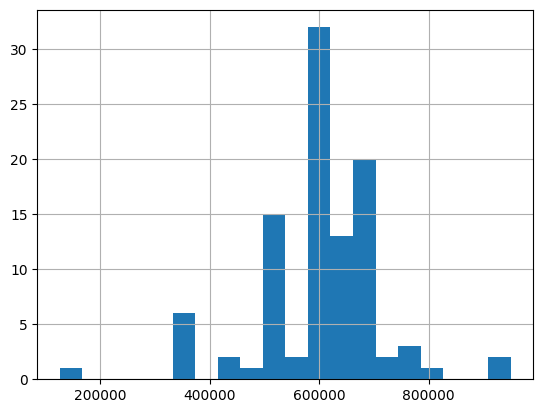

In [52]:
pd.Series(all_tree_predictions).hist(bins=20)

In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from forestci import random_forest_error


y_pred = regressor.predict(X_transf)
random_forest_error(
    regressor,
    X_train_transf.values.shape,
    X_test_transf.values,
)

# y_pred_low e y_pred_high fornecerão limites inferiores e superiores de confiança
# baseados nas estimativas de incerteza do forestci.


/opt/conda/lib/python3.11/site-packages/forestci/calibration.py:134: RuntimeWarning: invalid value encountered in divide
  post /= sum(post)


array([4.96439462e+12, 4.95379714e+12, 4.96639384e+12, ...,
       4.96654876e+12, 4.96633837e+12, 4.96648255e+12])

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

test = df_test.copy()

test["predicted_price"] = y_test_predicted

test["residuals"] = y_test_predicted - y_test

test["abs_residuals"] = test["residuals"].abs()

test["perc_residuals"] = test["residuals"] / y_test

test["perc_abs_residuals"] = test["abs_residuals"] / y_test

mae = mean_absolute_error(y_test, y_test_predicted)
mse = mean_squared_error(y_test, y_test_predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(residuals / y_test_predicted)) * 100000

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")


MAE: 94055.0740822736
MSE: 107515316910.85115
RMSE: 327895.28345319506
MAPE: 14763.767732994876 %


<Axes: >

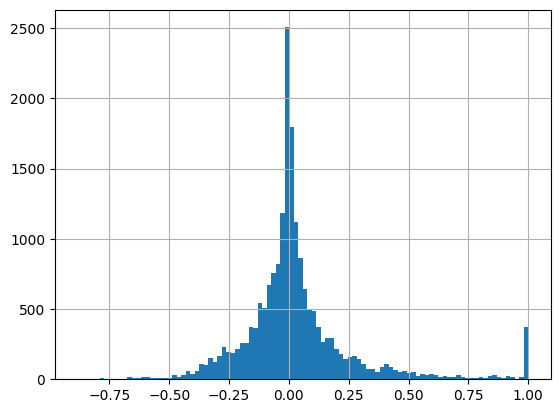

In [64]:
test["perc_residuals"].clip(-1,1).hist(bins=100)

In [67]:
test["overestimated"] = test["perc_residuals"] > 0
test["underestimated"] = test["perc_residuals"] < 0

test["down_outlier"] = test["perc_residuals"] < -0.50
test["up_outlier"] = test["perc_residuals"] > 0.50

In [87]:
test[["number_of_parking_spaces", "up_outlier"]].corr()

,number_of_parking_spaces,up_outlier
number_of_parking_spaces,1.000000,-0.002393
up_outlier,-0.002393,1.000000


In [80]:
# df_train[df_train["price"]==2500000.0]

In [76]:
test[((~test["overestimated"]) & (~test["underestimated"]))]

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu,predicted_price,residuals,abs_residuals,perc_residuals,perc_abs_residuals,down_outlier,up_outlier,overestimated,underestimated
519,3447b069-af50-43c6-8127-9b4c3352505a,2568094471,venda,2022-07-10,NaN,/imovel/venda-casa-4-quartos-com-piscina-borto...,Casa,NaN,Casa no bairro Campo da Cachoeira -Poços de Ca...,NaN,Bortolan Norte I,Poços de Caldas,MG,-21.782818,-46.629542,384.0,4.0,1.0,2.0,"['BARBECUE_GRILL', 'KITCHEN', 'GOURMET_BALCONY...",2500000.0,0.0,0.0,2500000.0,0.0,0.0,0.0,0.0,False,False,False,False
648,4556d688-1c4e-4b61-b573-b1c14934fadb,2568096796,venda,2022-10-16,NaN,/imovel/venda-casa-4-quartos-jardim-centenario...,Casa,NaN,"Casa em Poços de Caldas, no bairro Centenário!...",NaN,Jardim Centenario,Poços de Caldas,MG,-21.805588,-46.565064,780.0,4.0,1.0,12.0,[''],1100000.0,0.0,0.0,1100000.0,0.0,0.0,0.0,0.0,False,False,False,False
661,a2e84d6b-646a-4ec8-9509-4e5b40991e7e,2538581592,venda,2022-06-04,NaN,/imovel/venda-terreno-lote-condominio-bortolan...,Lote,NaN,Lote Vende - Residencial Campo da Cachoeira - ...,Avenida Ferrero,Bortolan Norte I,Poços de Caldas,MG,-21.786006,-46.631535,785.0,NaN,NaN,NaN,[''],471378.0,0.0,0.0,471378.0,0.0,0.0,0.0,0.0,False,False,False,False
884,9948c3d9-3eb1-4040-8b5f-09498bb0a488,2568096061,venda,2022-07-16,NaN,/imovel/venda-casa-4-quartos-com-piscina-jardi...,Casa,NaN,"Casa, no bairro Jardim Novo Mundo Poços de Cal...",NaN,Jardim Novo Mundo,Poços de Caldas,MG,-21.793979,-46.587632,1050.0,4.0,3.0,10.0,"['BARBECUE_GRILL', 'KITCHEN', 'GOURMET_BALCONY...",4200000.0,0.0,400.0,4200000.0,0.0,0.0,0.0,0.0,False,False,False,False
1129,2d75c1d9-4b15-47e8-8e85-a50cf3dacee5,2503298488,venda,2022-04-09,NaN,/imovel/venda-apartamento-2-quartos-com-churra...,Apartamento,NaN,"Casa, localizado no bairro jardim Bandeirantes...",NaN,Jardim Bandeirantes,Poços de Caldas,MG,-21.809666,-46.586492,98.0,2.0,1.0,1.0,"['BARBECUE_GRILL', 'GATED_COMMUNITY', 'INTERCOM']",348000.0,0.0,0.0,348000.0,0.0,0.0,0.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17878,f45cfb0d-c0b4-47e7-8524-55848549636e,2503298488,venda,2022-01-15,NaN,/imovel/venda-apartamento-2-quartos-com-churra...,Apartamento,NaN,"Casa, localizado no bairro jardim Bandeirantes...",NaN,Jardim Bandeirantes,Poços de Caldas,MG,-21.809666,-46.586492,98.0,2.0,1.0,1.0,"['BARBECUE_GRILL', 'GATED_COMMUNITY', 'INTERCOM']",348000.0,0.0,0.0,348000.0,0.0,0.0,0.0,0.0,False,False,False,False
17909,bd2ce445-96a9-4dd1-9bf5-b3bb31884384,2509305473,venda,2022-04-17,NaN,/imovel/venda-terreno-lote-condominio-loteamen...,Lote,NaN,"Terreno em Poços de Caldas, no bairro Jardim C...",NaN,Loteamento Caldense,Poços de Caldas,MG,-21.784877,-46.562902,509.0,0.0,0.0,0.0,[''],250000.0,0.0,391.0,250000.0,0.0,0.0,0.0,0.0,False,False,False,False
18213,6a5073a6-d5d6-4bc9-9ca3-42270e04ba7c,2503298488,venda,2022-04-17,NaN,/imovel/venda-apartamento-2-quartos-com-churra...,Apartamento,NaN,"Casa, localizado no bairro jardim Bandeirantes...",NaN,Jardim Bandeirantes,Poços de Caldas,MG,-21.809666,-46.586492,98.0,2.0,1.0,1.0,"['BARBECUE_GRILL', 'GATED_COMMUNITY', 'INTERCOM']",348000.0,0.0,0.0,348000.0,0.0,0.0,0.0,0.0,False,False,False,False
18863,52c3cc80-b0a8-422d-8bd7-0f83166e069d,2503298488,venda,2022-05-07,NaN,/imovel/venda-apartamento-2-quartos-com-churra...,Apartamento,NaN,"Casa, localizado no bairro jardim Bandeirantes...",NaN,Jardim Bandeirantes,Poços de Caldas,MG,-21.809666,-46.586492,98.0,2.0,1.0,1.0,"['BARBECUE_GRILL', 'GATED_COMMUNITY', 'INTERCOM']",348000.0,0.0,0.0,348000.0,0.0,0.0,0.0,0.0,False,False,False,False


In [33]:
df = pd.DataFrame({'y_test': y_test_predicted, 'y_pred': y_test_predicted, 'residuals': residuals})

# Criar faixas (bins) com base em quantis do y_test
df['y_bin'] = pd.qcut(df['y_test'], q=4, duplicates='drop')  # 4 faixas (quartis), por exemplo

# Calcular métricas por faixa
grouped = df.groupby('y_bin').agg(
    MAE=('residuals', lambda x: np.mean(np.abs(x))),
    MSE=('residuals', lambda x: np.mean(x**2)),
    RMSE=('residuals', lambda x: np.sqrt(np.mean(x**2)))
)

print(grouped)


                                   MAE           MSE           RMSE
y_bin                                                              
(70499.999, 272112.3]     26391.550591  2.256018e+09   47497.557037
(272112.3, 400000.18]     46759.560502  1.136329e+10  106598.738029
(400000.18, 632574.95]    71483.654111  1.368901e+10  117000.041452
(632574.95, 54079500.0]  231580.882974  4.027336e+11  634612.974452


/tmp/ipykernel_88/2847633807.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('y_bin').agg(


In [25]:
y_train_predicted

array([352640. , 354510. , 401000. , ..., 223189.8, 897400. , 350000. ])

In [26]:
y_test_predicted

array([347169.94, 375549.98, 438984.8 , ..., 345540.  , 214985.  ,
       184045.  ])

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-j8b5ksph because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


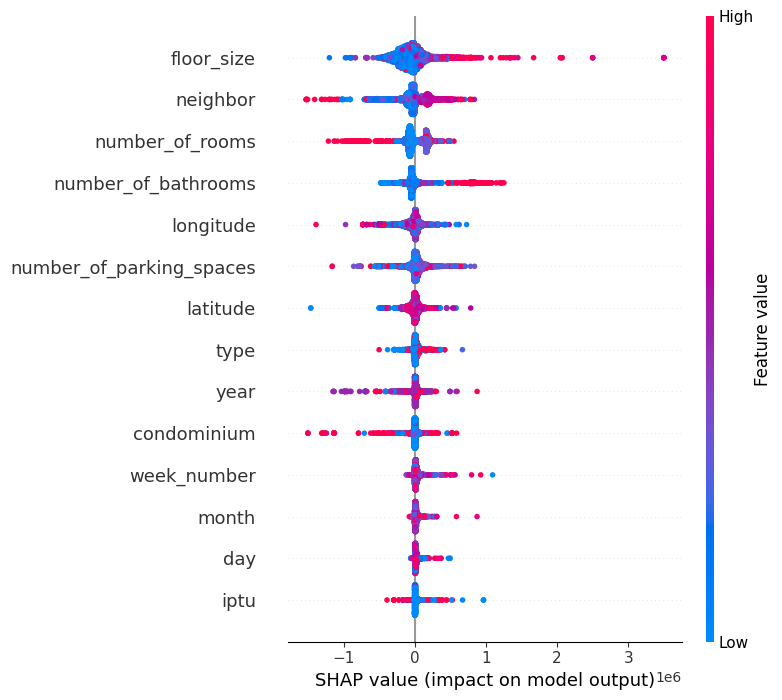

Métricas no conjunto de teste: {'mae_test': 94055.0740822736, 'r2_test': 0.9042963361520342}


In [12]:
import shap
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

for step_name, step in pipeline.named_steps.items():
    if step_name != 'regressor':
        X_train_transformed = step.transform(X_train_transformed)
        X_test_transformed = step.transform(X_test_transformed)

# 2. Selecionar um background pequeno do treinamento
background = X_train_transformed.sample(500, random_state=42)

# 3. Selecionar uma subamostra do conjunto de teste para explicar
X_test_sample = X_test_transformed.sample(5000, random_state=42)

# 4. Extrair o modelo RandomForestRegressor do pipeline
rf_model = pipeline.named_steps['regressor']

# 5. Criar o TreeExplainer com background reduzido
explainer = shap.TreeExplainer(rf_model, data=background, model_output='raw')

# 6. Calcular os valores SHAP com aproximação
shap_values = explainer.shap_values(X_test_sample, approximate=True)

# Agora você pode criar plots explicativos.
# Por exemplo, um gráfico de resumo global:
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

# Fornecer um exemplo individual (caso queira explicar uma única predição)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_sample.iloc[i,:])

# Caso queira métricas do modelo (apenas para referência):
y_test_pred = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Métricas no conjunto de teste:", {"mae_test": mae_test, "r2_test": r2_test})


array([609709.2])

### Experimento 2

In [12]:
%%time

selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    # "number_of_rooms",
    # "number_of_bathrooms",
    # "number_of_parking_spaces",
]


# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = {}

pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, **best_params))
])


################ OTIMIZACAO
# fold_metrics = []

# for fold in tqdm(folds, desc="Fold", leave=False):
#     data_train = fold.data_train
#     data_val = fold.data_val

#     X_train = data_train.drop(columns=TARGET_COLUMN)
#     X_val = data_val.drop(columns=TARGET_COLUMN)

#     y_train = data_train[TARGET_COLUMN]
#     y_val = data_val[TARGET_COLUMN]

#     pipeline.fit(X_train, y_train)


#     y_train_predicted = pipeline.predict(X_train)
#     y_val_predicted = pipeline.predict(X_val)

#     fold_metrics.append(
#         {
#             "mae_train": mean_absolute_error(y_train, y_train_predicted),
#             "mae_val": mean_absolute_error(y_val, y_val_predicted),
#             "r2_train": r2_score(y_train, y_train_predicted),
#             "r2_val": r2_score(y_val, y_val_predicted),
#         }
#     )

# metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()

# print(metrics_agg)


X_train = df_train.drop(columns=TARGET_COLUMN)
X_test = df_test.drop(columns=TARGET_COLUMN)

y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict(X_train)
y_test_predicted = pipeline.predict(X_test)

print(
    {
        "mae_train": mean_absolute_error(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(y_test, y_test_predicted),
        "r2_train": r2_score(y_train, y_train_predicted),
        "r2_val": r2_score(y_test, y_test_predicted),
    }
)


{'mae_train': 21537.99003331, 'mae_val': 98438.26286310046, 'r2_train': 0.917884143428386, 'r2_val': 0.8728067699390849}
CPU times: user 38 s, sys: 123 ms, total: 38.1 s
Wall time: 38.1 s


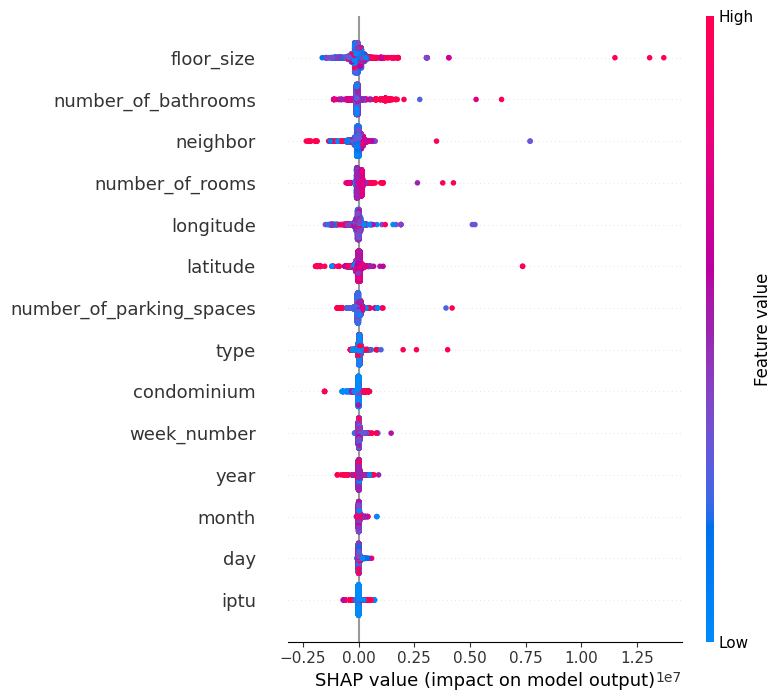

Métricas no conjunto de teste: {'mae_test': 98438.26286310046, 'r2_test': 0.8728067699390849}


In [13]:
import shap
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

for step_name, step in pipeline.named_steps.items():
    if step_name != 'regressor':
        X_train_transformed = step.transform(X_train_transformed)
        X_test_transformed = step.transform(X_test_transformed)

# 2. Selecionar um background pequeno do treinamento
background = X_train_transformed.sample(500, random_state=42)

# 3. Selecionar uma subamostra do conjunto de teste para explicar
X_test_sample = X_test_transformed.sample(5000, random_state=42)

# 4. Extrair o modelo RandomForestRegressor do pipeline
rf_model = pipeline.named_steps['regressor']

# 5. Criar o TreeExplainer com background reduzido
explainer = shap.TreeExplainer(rf_model, data=background, model_output='raw')

# 6. Calcular os valores SHAP com aproximação
shap_values = explainer.shap_values(X_test_sample, approximate=True)

# Agora você pode criar plots explicativos.
# Por exemplo, um gráfico de resumo global:
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

# Fornecer um exemplo individual (caso queira explicar uma única predição)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_sample.iloc[i,:])

# Caso queira métricas do modelo (apenas para referência):
y_test_pred = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Métricas no conjunto de teste:", {"mae_test": mae_test, "r2_test": r2_test})


### Experimento 3

In [44]:
%%time

selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    # "number_of_rooms",
    # "number_of_bathrooms",
    # "number_of_parking_spaces",
]


# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = {}

pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, **best_params))
])


################ OTIMIZACAO
# fold_metrics = []

# for fold in tqdm(folds, desc="Fold", leave=False):
#     data_train = fold.data_train
#     data_val = fold.data_val

#     X_train = data_train.drop(columns=TARGET_COLUMN)
#     X_val = data_val.drop(columns=TARGET_COLUMN)

#     y_train = data_train[TARGET_COLUMN]
#     y_val = data_val[TARGET_COLUMN]

#     pipeline.fit(X_train, y_train)


#     y_train_predicted = pipeline.predict(X_train)
#     y_val_predicted = pipeline.predict(X_val)

#     fold_metrics.append(
#         {
#             "mae_train": mean_absolute_error(y_train, y_train_predicted),
#             "mae_val": mean_absolute_error(y_val, y_val_predicted),
#             "r2_train": r2_score(y_train, y_train_predicted),
#             "r2_val": r2_score(y_val, y_val_predicted),
#         }
#     )

# metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()

# print(metrics_agg)


X_train = df_train.drop(columns=TARGET_COLUMN)
X_test = df_test.drop(columns=TARGET_COLUMN)

y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict(X_train)
y_test_predicted = pipeline.predict(X_test)

print(
    {
        "mae_train": mean_absolute_error(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(y_test, y_test_predicted),
        "r2_train": r2_score(y_train, y_train_predicted),
        "r2_val": r2_score(y_test, y_test_predicted),
    }
)


{'mae_train': 21537.99003331, 'mae_val': 98438.26286310046, 'r2_train': 0.917884143428386, 'r2_val': 0.8728067699390849}
CPU times: user 37.6 s, sys: 19.9 ms, total: 37.7 s
Wall time: 37.7 s


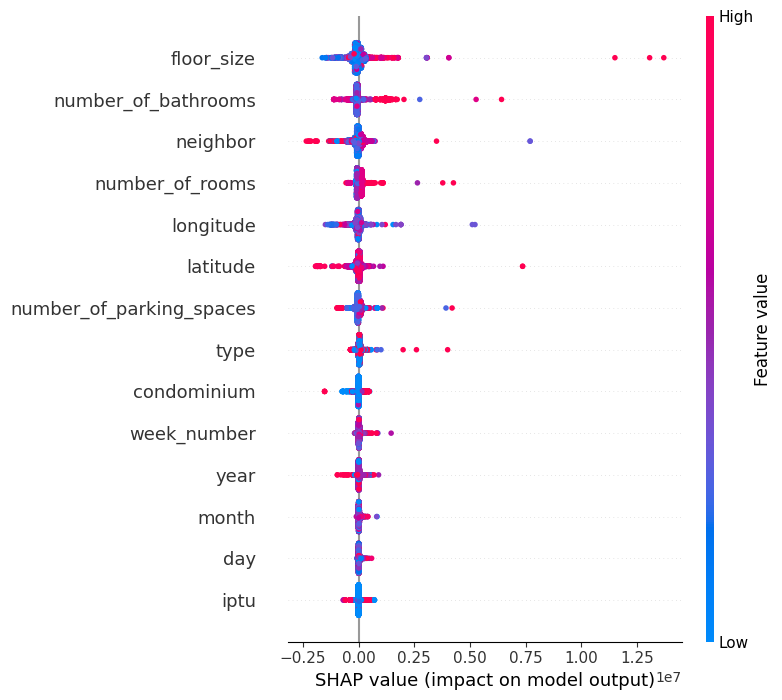

Métricas no conjunto de teste: {'mae_test': 98438.26286310046, 'r2_test': 0.8728067699390849}


In [46]:
import shap
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

for step_name, step in pipeline.named_steps.items():
    if step_name != 'regressor':
        X_train_transformed = step.transform(X_train_transformed)
        X_test_transformed = step.transform(X_test_transformed)

# 2. Selecionar um background pequeno do treinamento
background = X_train_transformed.sample(500, random_state=42)

# 3. Selecionar uma subamostra do conjunto de teste para explicar
X_test_sample = X_test_transformed.sample(5000, random_state=42)

# 4. Extrair o modelo RandomForestRegressor do pipeline
rf_model = pipeline.named_steps['regressor']

# 5. Criar o TreeExplainer com background reduzido
explainer = shap.TreeExplainer(rf_model, data=background, model_output='raw')

# 6. Calcular os valores SHAP com aproximação
shap_values = explainer.shap_values(X_test_sample, approximate=True)

# Agora você pode criar plots explicativos.
# Por exemplo, um gráfico de resumo global:
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

# Fornecer um exemplo individual (caso queira explicar uma única predição)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_sample.iloc[i,:])

# Caso queira métricas do modelo (apenas para referência):
y_test_pred = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Métricas no conjunto de teste:", {"mae_test": mae_test, "r2_test": r2_test})


In [98]:
values = {
    'search_date': '2022-07-10',
    'type': 'Casa',
    'neighbor': 'Jardim Ipê',
    'latitude': -21.80226879207351,
    'longitude': -46.54717547244256,
    'floor_size': 160.0,
    'number_of_rooms': 3.0,
    'number_of_bathrooms': 3.0,
    'number_of_parking_spaces': 2.0,
    'condominium': None,
    'iptu': None,
}
pipeline.predict(pd.DataFrame([values]))

array([627360.])

In [106]:
values = {
    'search_date': '2024-07-10',
    'type': 'Casa',
    'neighbor': 'Dom Bosco',
    'latitude': -21.80226879207351,
    'longitude': -46.54717547244256,
    'floor_size': 160.0,
    'number_of_rooms': 0.0,
    'number_of_bathrooms': 3.0,
    'number_of_parking_spaces': 2.0,
    'condominium': None,
    'iptu': None,
}
pipeline.predict(pd.DataFrame([values]))

array([552130.])

### É preciso garantir Monotonic Constraints

# LightGBM

In [116]:
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [148]:
%%time


selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]


monotonic_constraints = {
    'type': 0,
    'neighbor': 0,
    'latitude': 0,
    'longitude': 0,
    'floor_size': 1,
    'number_of_rooms': 1,
    'number_of_bathrooms': 1,
    'number_of_parking_spaces': 1,
    'condominium': 1,
    'iptu': 1,
    'year': 0,
    'month': 0,
    'day': 0,
    'week_number': 0
}




# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = dict(
    monotone_constraints=str(tuple(monotonic_constraints.values())),
)

pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=42, **best_params))
])


################ OTIMIZACAO
# fold_metrics = []

# for fold in tqdm(folds, desc="Fold", leave=False):
#     data_train = fold.data_train
#     data_val = fold.data_val

#     X_train = data_train.drop(columns=TARGET_COLUMN)
#     X_val = data_val.drop(columns=TARGET_COLUMN)

#     y_train = data_train[TARGET_COLUMN]
#     y_val = data_val[TARGET_COLUMN]

#     pipeline.fit(X_train, y_train)


#     y_train_predicted = pipeline.predict(X_train)
#     y_val_predicted = pipeline.predict(X_val)

#     fold_metrics.append(
#         {
#             "mae_train": mean_absolute_error(y_train, y_train_predicted),
#             "mae_val": mean_absolute_error(y_val, y_val_predicted),
#             "r2_train": r2_score(y_train, y_train_predicted),
#             "r2_val": r2_score(y_val, y_val_predicted),
#         }
#     )

# metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()

# print(metrics_agg)


X_train = df_train.drop(columns=TARGET_COLUMN)
X_test = df_test.drop(columns=TARGET_COLUMN)

y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict(X_train)
y_test_predicted = pipeline.predict(X_test)

print(
    {
        "mae_train": mean_absolute_error(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(y_test, y_test_predicted),
        "r2_train": r2_score(y_train, y_train_predicted),
        "r2_val": r2_score(y_test, y_test_predicted),
    }
)


{'mae_train': 126142.66075529066, 'mae_val': 152518.09029674192, 'r2_train': 0.7685815591270048, 'r2_val': 0.5162062667394166}
CPU times: user 3.92 s, sys: 26.8 ms, total: 3.95 s
Wall time: 716 ms


'(0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0)'

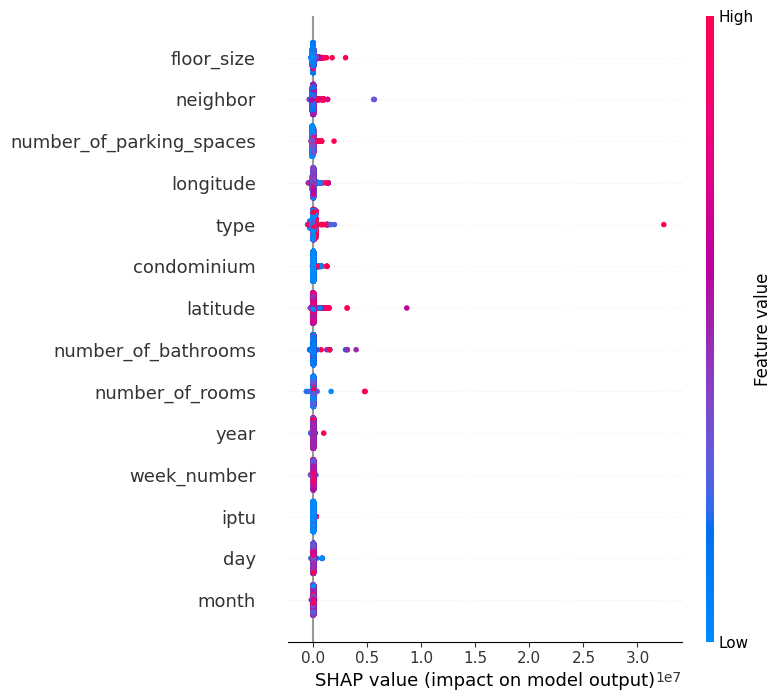

Métricas no conjunto de teste: {'mae_test': 152518.09029674192, 'r2_test': 0.5162062667394166}


In [149]:
import shap
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

for step_name, step in pipeline.named_steps.items():
    if step_name != 'regressor':
        X_train_transformed = step.transform(X_train_transformed)
        X_test_transformed = step.transform(X_test_transformed)

# 2. Selecionar um background pequeno do treinamento
background = X_train_transformed.sample(500, random_state=42)

# 3. Selecionar uma subamostra do conjunto de teste para explicar
X_test_sample = X_test_transformed.sample(5000, random_state=42)

# 4. Extrair o modelo RandomForestRegressor do pipeline
rf_model = pipeline.named_steps['regressor']

# 5. Criar o TreeExplainer com background reduzido
explainer = shap.TreeExplainer(rf_model, data=background, model_output='raw')

# 6. Calcular os valores SHAP com aproximação
shap_values = explainer.shap_values(X_test_sample, approximate=True, check_additivity=False)

# Agora você pode criar plots explicativos.
# Por exemplo, um gráfico de resumo global:
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

# Fornecer um exemplo individual (caso queira explicar uma única predição)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_sample.iloc[i,:])

# Caso queira métricas do modelo (apenas para referência):
y_test_pred = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Métricas no conjunto de teste:", {"mae_test": mae_test, "r2_test": r2_test})


In [157]:
values = {
    'search_date': '2022-07-10',
    'type': 'Casa',
    'neighbor': 'Jardim Ipê',
    'latitude': -21.80226879207351,
    'longitude': -46.54717547244256,
    'floor_size': 160.0,
    'number_of_rooms': 6.0,
    'number_of_bathrooms': 5.0,
    'number_of_parking_spaces': 2.0,
    'condominium': None,
    'iptu': None,
}

X_inference = pd.DataFrame([values])


pipeline.predict(X_inference)

# preprocessing_pipeline = Pipeline(pipeline.steps[:-1])

# preprocessing_pipeline.transform(X_inference)


array([988387.75], dtype=float32)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [137]:
{x: 0  for x in preprocessing_pipeline.transform(X_inference).columns}

{'type': 0,
 'neighbor': 0,
 'latitude': 0,
 'longitude': 0,
 'floor_size': 0,
 'number_of_rooms': 0,
 'number_of_bathrooms': 0,
 'number_of_parking_spaces': 0,
 'condominium': 0,
 'iptu': 0,
 'year': 0,
 'month': 0,
 'day': 0,
 'week_number': 0}

In [134]:
X_inference

array([698073.5], dtype=float32)

In [77]:
preprocessing_pipeline = Pipeline(pipeline.steps[:-1])

transf = preprocessing_pipeline.transform(X_pred)


transf

,type,neighbor,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,condominium,iptu,year,month,day,week_number
0,1.381884,-0.766539,-0.159232,-0.166496,-0.013084,1.534893,1.103439,0.307057,-0.036579,-0.015203,-0.137415,0.123731,-0.604918,0.040608


In [ ]:
monotonic_cst=[1, -1]

In [50]:
X_test[selected_columns].iloc[0].to_dict()

{'search_date': '2022-07-10',
 'type': 'Apartamento',
 'neighbor': 'Residencial Veredas',
 'latitude': -21.7916163,
 'longitude': -46.608054,
 'floor_size': 52.0,
 'number_of_rooms': 2.0,
 'number_of_bathrooms': 2.0,
 'number_of_parking_spaces': 1.0,
 'condominium': 1.0,
 'iptu': 0.0}

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
3,f484ce2a-717c-45ee-ad63-58272f6ef6aa,2489043306,venda,2023-04-28,NaN,/imovel/venda-casa-4-quartos-com-lareira-jardi...,Casa,NaN,"Casa Alto Padrão, Arquitetura Moderna - em Poç...",Rua Anderson de Faria,Jardim Santa Augusta,Poços de Caldas,MG,-21.791625,-46.570879,430.0,4.0,5.0,6.0,"['FIREPLACE', 'SAUNA']",2085000.0,0.0,0.0
5,d6ac34cb-743c-42ec-aa59-db1c86e44717,2556857530,venda,2022-04-03,NaN,/imovel/venda-casa-3-quartos-com-sala-de-janta...,Casa,NaN,Casa no estilo assobradada com 240 m² de área ...,NaN,Residencial Morumbi,Poços de Caldas,MG,-21.807490,-46.579703,240.0,3.0,1.0,2.0,['DINNER_ROOM'],740000.0,0.0,0.0
9,7dea955c-f7ce-4bf0-b9fe-4f2c88019b67,2548305738,venda,2022-04-03,NaN,/imovel/venda-casa-2-quartos-santa-emilia-poco...,Casa,NaN,Casa à venda - Santa Emília <br> Casa com 02 d...,NaN,Santa Emilia,Poços de Caldas,MG,-21.787091,-46.558482,300.0,2.0,2.0,1.0,"['GARAGE', 'KITCHEN', 'HEATING']",380000.0,0.0,0.0
10,34dc1852-429b-4f9a-9cef-c9bce516c7a1,2504721182,venda,2022-04-17,NaN,/imovel/venda-casa-3-quartos-com-interfone-jar...,Casa,NaN,"Casa em Poços de Caldas/MG, com 03 quartos, se...",NaN,Jardim Ipê,Poços de Caldas,MG,-21.799761,-46.547920,300.0,3.0,2.0,5.0,['INTERCOM'],420000.0,0.0,0.0
14,00af34e5-4985-4662-8b85-6b24a6cb4c88,2563572934,venda,2022-08-13,NaN,/imovel/venda-casa-3-quartos-com-sala-de-janta...,Casa,NaN,Casa no estilo assobradada com área total cons...,NaN,Jardim Centenario,Poços de Caldas,MG,-21.805588,-46.565064,273.0,3.0,3.0,3.0,['DINNER_ROOM'],780000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77144,3dd588c9-b754-431a-9e9f-a44ea62c046a,2538408981,venda,2022-05-15,NaN,/imovel/venda-casa-3-quartos-com-cozinha-conju...,Casa,NaN,Casa a venda na COHAB Poços de Caldas.<br>3 qu...,NaN,Conjunto Habitacional Pedro Afonso Junqueira,Poços de Caldas,MG,-21.848928,-46.569512,173.0,3.0,1.0,2.0,"['KITCHEN', 'INTERCOM', 'BACKYARD', 'SERVICE_A...",350000.0,0.0,0.0
77148,371c0a81-ff55-4138-8ce0-f9b82dbfffe9,2539325585,venda,2022-01-15,NaN,/imovel/venda-casa-3-quartos-com-cozinha-jardi...,Casa,NaN,03 Dormitórios (sendo 01 suíte com closed)<br>...,NaN,Jardim Vitoria,Poços de Caldas,MG,-21.802387,-46.571022,161.0,3.0,1.0,2.0,"['KITCHEN', 'INTERCOM', 'BACKYARD', 'SERVICE_A...",620000.0,0.0,0.0
77151,b725d833-cc56-455a-a4c0-731cf094e098,2500687645,venda,2021-06-04,NaN,/imovel/venda-casa-3-quartos-com-churrasqueira...,Casa,NaN,Casa no bairro Jardim dos Estados -Poços de Ca...,Rua Uberaba,Jardim dos Estados,Poços de Caldas,MG,-21.780987,-46.557575,567.0,3.0,2.0,4.0,"['BARBECUE_GRILL', 'KITCHEN_CABINETS', 'BUILTI...",990000.0,NaN,NaN
77152,172c33e0-3e73-4c08-ade6-fe0e1b1a4e40,2517760171,venda,2021-06-04,NaN,/imovel/venda-casa-3-quartos-com-piscina-jardi...,Casa,NaN,Casa de alto padrão no Jardim Novo Mundo II em...,Rua Santiago,Jardim Novo Mundo,Poços de Caldas,MG,-21.793979,-46.587632,363.0,3.0,4.0,3.0,"['BARBECUE_GRILL', 'KITCHEN', 'DEPOSIT', 'INTE...",1080000.0,0.0,3026.0


In [25]:
# pd.DataFrame(zip(selected_columns,rf_model.feature_importances_), columns=["feature", "importance"]).sort_values("importance", ascending=False)

,feature,importance
4,longitude,0.588906
6,number_of_rooms,0.109473
1,type,0.091380
3,latitude,0.060285
0,search_date,0.050878
5,floor_size,0.035193
2,neighbor,0.022835
7,number_of_bathrooms,0.013005
10,iptu,0.012597
8,number_of_parking_spaces,0.007266


In [77]:
X_train[selected_columns]

,search_date,type,neighbor,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,condominium,iptu
1,2022-07-24,Apartamento,Jardim Das Azaléias,-21.807995,-46.545358,65.0,2.0,1.0,1.0,0.0,0.0
2,2021-12-30,Lote,Santo André,-21.791427,-46.545614,332.0,0.0,0.0,0.0,0.0,351.0
3,2022-04-09,Apartamento,Jardim Quisisana,-21.797683,-46.565872,100.0,3.0,1.0,1.0,110.0,650.0
5,2022-04-23,Apartamento,Pqe Nações,-21.850109,-46.565568,82.0,3.0,1.0,2.0,0.0,0.0
8,2021-06-04,Lote,Jardim Nova Aparecida,-21.792098,-46.550284,170.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
77149,2022-04-09,Apartamento,Vila Togni,-21.780299,-46.597623,80.0,3.0,2.0,1.0,220.0,0.0
77150,2022-05-01,Lote,Centro,-21.794901,-46.532802,250.0,NaN,0.0,NaN,0.0,300.0
77151,2022-09-26,Apartamento,Jardim Quisisana,-21.797683,-46.565872,107.0,3.0,2.0,2.0,210.0,0.0
77152,2022-08-13,Casa,Jardim Das Azaléias,-21.799337,-46.550628,82.0,2.0,2.0,2.0,0.0,0.0


In [ ]:
1

In [73]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

best_params = {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}

def create_pipeline():
    pipeline_sem_fit = Pipeline([
        ('filter_columns', ColumnSelector(columns=selected_columns)),
        ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
        ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
        ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    return pipeline_sem_fit

# Definindo dados de treino e teste, ajuste conforme sua lógica.
train = df_train.sample(20000, random_state=42)
test = df_test.sample(10000, random_state=42)

X_train = train.drop(columns=TARGET_COLUMN)
X_test = test.drop(columns=TARGET_COLUMN)
y_train = train[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

def objective(trial):
    # Cria uma nova pipeline "limpa" para cada trial
    trial_pipeline = create_pipeline()

    # Sugerir hiperparâmetros para o RandomForestRegressor
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
    max_depth = trial.suggest_categorical('max_depth', [5, 10, 15, None])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
    max_features = trial.suggest_categorical('max_features', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    trial_pipeline.set_params(
        regressor__n_estimators=n_estimators,
        regressor__max_depth=max_depth,
        regressor__min_samples_split=min_samples_split,
        regressor__min_samples_leaf=min_samples_leaf,
        regressor__max_features=max_features,
        regressor__bootstrap=bootstrap
    )

    # Cross-validation para avaliar a pipeline
    scores = cross_val_score(
        trial_pipeline,
        X_train,
        y_train,
        scoring='rmse',
        cv=3,
        n_jobs=-1
    )

    # Negamos para transformar em MAE positivo (quanto menor melhor)
    return scores.mean()

study = optuna.create_study(direction='minimize')

try:
    study.enqueue_trial(best_params)
except NameError:
    pass

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Melhores parâmetros encontrados pelo Optuna:")
best_params = study.best_params
print(best_params)

# Ajustar o pipeline com os melhores parâmetros finais
final_pipeline = create_pipeline()
final_pipeline.set_params(
    regressor__n_estimators=best_params['n_estimators'],
    regressor__max_depth=best_params['max_depth'],
    regressor__min_samples_split=best_params['min_samples_split'],
    regressor__min_samples_leaf=best_params['min_samples_leaf'],
    regressor__max_features=best_params['max_features'],
    regressor__bootstrap=best_params['bootstrap']
)

final_pipeline.fit(X_train, y_train)
y_train_predicted = final_pipeline.predict(X_train)
y_test_predicted = final_pipeline.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_predicted)
mae_test = mean_absolute_error(y_test, y_test_predicted)
r2_train = r2_score(y_train, y_train_predicted)
r2_test = r2_score(y_test, y_test_predicted)

print("Métricas após tuning com Optuna (RandomForest):")
print({
    "mae_train": mae_train,
    "mae_test": mae_test,
    "r2_train": r2_train,
    "r2_test": r2_test,
})


[I 2024-12-06 02:30:45,978] A new study created in memory with name: no-name-bc10d3af-0341-4587-899f-cc7d358beedf
Best trial: 0. Best value: 186617:   1%|          | 1/100 [00:06<10:22,  6.29s/it]

[I 2024-12-06 02:30:52,261] Trial 0 finished with value: 186617.3118895235 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 0 with value: 186617.3118895235.


Best trial: 1. Best value: 173016:   2%|▏         | 2/100 [00:11<08:46,  5.37s/it]

[I 2024-12-06 02:30:56,989] Trial 1 finished with value: 173016.13591145433 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.1, 'bootstrap': False}. Best is trial 1 with value: 173016.13591145433.


Best trial: 2. Best value: 120237:   3%|▎         | 3/100 [00:19<11:00,  6.81s/it]

[I 2024-12-06 02:31:05,507] Trial 2 finished with value: 120237.25903381285 and parameters: {'n_estimators': 600, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.4, 'bootstrap': True}. Best is trial 2 with value: 120237.25903381285.


Best trial: 2. Best value: 120237:   4%|▍         | 4/100 [00:42<20:53, 13.06s/it]

[I 2024-12-06 02:31:28,160] Trial 3 finished with value: 139955.06186189735 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'bootstrap': False}. Best is trial 2 with value: 120237.25903381285.


Best trial: 2. Best value: 120237:   5%|▌         | 5/100 [00:44<14:33,  9.20s/it]

[I 2024-12-06 02:31:30,510] Trial 4 finished with value: 127598.71143335469 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'bootstrap': True}. Best is trial 2 with value: 120237.25903381285.


Best trial: 2. Best value: 120237:   6%|▌         | 6/100 [00:50<12:30,  7.98s/it]

[I 2024-12-06 02:31:36,119] Trial 5 finished with value: 135050.96489289516 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.4, 'bootstrap': False}. Best is trial 2 with value: 120237.25903381285.


Best trial: 6. Best value: 99024.1:   7%|▋         | 7/100 [01:14<20:30, 13.23s/it]

[I 2024-12-06 02:32:00,169] Trial 6 finished with value: 99024.0513357551 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:   8%|▊         | 8/100 [01:16<14:59,  9.78s/it]

[I 2024-12-06 02:32:02,553] Trial 7 finished with value: 186692.26872678535 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.4, 'bootstrap': False}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:   9%|▉         | 9/100 [01:28<15:42, 10.35s/it]

[I 2024-12-06 02:32:14,170] Trial 8 finished with value: 105179.32850857147 and parameters: {'n_estimators': 400, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  10%|█         | 10/100 [01:32<12:46,  8.51s/it]

[I 2024-12-06 02:32:18,554] Trial 9 finished with value: 168989.99851835932 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.1, 'bootstrap': False}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  11%|█         | 11/100 [01:56<19:31, 13.16s/it]

[I 2024-12-06 02:32:42,251] Trial 10 finished with value: 99024.0513357551 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  12%|█▏        | 12/100 [02:19<23:46, 16.22s/it]

[I 2024-12-06 02:33:05,461] Trial 11 finished with value: 99024.0513357551 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  13%|█▎        | 13/100 [02:42<26:31, 18.30s/it]

[I 2024-12-06 02:33:28,551] Trial 12 finished with value: 99024.0513357551 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  14%|█▍        | 14/100 [03:06<28:28, 19.86s/it]

[I 2024-12-06 02:33:52,024] Trial 13 finished with value: 99024.0513357551 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  15%|█▌        | 15/100 [03:29<29:32, 20.85s/it]

[I 2024-12-06 02:34:15,170] Trial 14 finished with value: 101546.13451206275 and parameters: {'n_estimators': 1000, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  16%|█▌        | 16/100 [03:31<21:12, 15.15s/it]

[I 2024-12-06 02:34:17,069] Trial 15 finished with value: 132919.12967629443 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.2, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 6. Best value: 99024.1:  17%|█▋        | 17/100 [03:41<18:54, 13.67s/it]

[I 2024-12-06 02:34:27,310] Trial 16 finished with value: 109646.89339049818 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': True}. Best is trial 6 with value: 99024.0513357551.


Best trial: 17. Best value: 96220.4:  18%|█▊        | 18/100 [04:10<25:13, 18.45s/it]

[I 2024-12-06 02:34:56,886] Trial 17 finished with value: 96220.36890387554 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  19%|█▉        | 19/100 [04:37<28:06, 20.82s/it]

[I 2024-12-06 02:35:23,235] Trial 18 finished with value: 98977.61375435414 and parameters: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  20%|██        | 20/100 [04:39<20:24, 15.31s/it]

[I 2024-12-06 02:35:25,682] Trial 19 finished with value: 182575.0635176118 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  21%|██        | 21/100 [05:03<23:22, 17.75s/it]

[I 2024-12-06 02:35:49,133] Trial 20 finished with value: 98990.63900088509 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  22%|██▏       | 22/100 [05:26<25:14, 19.41s/it]

[I 2024-12-06 02:36:12,421] Trial 21 finished with value: 98990.63900088512 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  23%|██▎       | 23/100 [05:49<26:22, 20.55s/it]

[I 2024-12-06 02:36:35,630] Trial 22 finished with value: 98990.63900088509 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  24%|██▍       | 24/100 [05:59<22:06, 17.46s/it]

[I 2024-12-06 02:36:45,860] Trial 23 finished with value: 99178.04001294741 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  25%|██▌       | 25/100 [06:33<27:41, 22.15s/it]

[I 2024-12-06 02:37:18,977] Trial 24 finished with value: 99042.72273915804 and parameters: {'n_estimators': 1000, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  26%|██▌       | 26/100 [06:49<25:18, 20.51s/it]

[I 2024-12-06 02:37:35,666] Trial 25 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  27%|██▋       | 27/100 [07:06<23:34, 19.38s/it]

[I 2024-12-06 02:37:52,406] Trial 26 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  28%|██▊       | 28/100 [07:10<17:42, 14.75s/it]

[I 2024-12-06 02:37:56,357] Trial 27 finished with value: 178916.3416115325 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.6, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  29%|██▉       | 29/100 [07:16<14:31, 12.28s/it]

[I 2024-12-06 02:38:02,860] Trial 28 finished with value: 130296.95089340761 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  30%|███       | 30/100 [07:26<13:13, 11.33s/it]

[I 2024-12-06 02:38:11,997] Trial 29 finished with value: 197106.2718062875 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': False}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  31%|███       | 31/100 [07:29<10:18,  8.96s/it]

[I 2024-12-06 02:38:15,423] Trial 30 finished with value: 141459.27451183135 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.2, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  32%|███▏      | 32/100 [07:46<12:49, 11.31s/it]

[I 2024-12-06 02:38:32,220] Trial 31 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  33%|███▎      | 33/100 [08:02<14:26, 12.94s/it]

[I 2024-12-06 02:38:48,950] Trial 32 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  34%|███▍      | 34/100 [08:19<15:25, 14.02s/it]

[I 2024-12-06 02:39:05,483] Trial 33 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  35%|███▌      | 35/100 [08:26<12:57, 11.97s/it]

[I 2024-12-06 02:39:12,674] Trial 34 finished with value: 111996.14587997606 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': False}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  36%|███▌      | 36/100 [08:39<12:55, 12.11s/it]

[I 2024-12-06 02:39:25,122] Trial 35 finished with value: 109344.22518910642 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.6, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  37%|███▋      | 37/100 [08:41<09:38,  9.18s/it]

[I 2024-12-06 02:39:27,466] Trial 36 finished with value: 126429.3993955399 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  38%|███▊      | 38/100 [08:44<07:32,  7.30s/it]

[I 2024-12-06 02:39:30,387] Trial 37 finished with value: 163531.5901571849 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.1, 'bootstrap': False}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  39%|███▉      | 39/100 [09:08<12:38, 12.43s/it]

[I 2024-12-06 02:39:54,771] Trial 38 finished with value: 107835.51481969185 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  40%|████      | 40/100 [09:18<11:32, 11.54s/it]

[I 2024-12-06 02:40:04,230] Trial 39 finished with value: 126371.04732169221 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.8, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  41%|████      | 41/100 [09:24<09:48,  9.97s/it]

[I 2024-12-06 02:40:10,546] Trial 40 finished with value: 102868.55013837425 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': False}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  42%|████▏     | 42/100 [09:41<11:34, 11.98s/it]

[I 2024-12-06 02:40:27,210] Trial 41 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  43%|████▎     | 43/100 [09:57<12:43, 13.39s/it]

[I 2024-12-06 02:40:43,886] Trial 42 finished with value: 98906.63486923675 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  44%|████▍     | 44/100 [10:04<10:30, 11.27s/it]

[I 2024-12-06 02:40:50,205] Trial 43 finished with value: 108801.5254665002 and parameters: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.4, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  45%|████▌     | 45/100 [10:21<11:56, 13.02s/it]

[I 2024-12-06 02:41:07,324] Trial 44 finished with value: 98443.6018531394 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  46%|████▌     | 46/100 [10:43<14:14, 15.82s/it]

[I 2024-12-06 02:41:29,677] Trial 45 finished with value: 96326.89418077753 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  47%|████▋     | 47/100 [10:46<10:28, 11.86s/it]

[I 2024-12-06 02:41:32,287] Trial 46 finished with value: 167234.06065308105 and parameters: {'n_estimators': 600, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.1, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 17. Best value: 96220.4:  48%|████▊     | 48/100 [10:52<08:49, 10.18s/it]

[I 2024-12-06 02:41:38,552] Trial 47 finished with value: 183469.1314826986 and parameters: {'n_estimators': 600, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'bootstrap': True}. Best is trial 17 with value: 96220.36890387554.


Best trial: 48. Best value: 84967.1:  49%|████▉     | 49/100 [11:25<14:24, 16.94s/it]

[I 2024-12-06 02:42:11,273] Trial 48 finished with value: 84967.1287694802 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  50%|█████     | 50/100 [11:45<14:54, 17.89s/it]

[I 2024-12-06 02:42:31,386] Trial 49 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  51%|█████     | 51/100 [11:55<12:46, 15.65s/it]

[I 2024-12-06 02:42:41,793] Trial 50 finished with value: 129874.2464157701 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  52%|█████▏    | 52/100 [12:15<13:34, 16.97s/it]

[I 2024-12-06 02:43:01,856] Trial 51 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  53%|█████▎    | 53/100 [12:36<14:02, 17.93s/it]

[I 2024-12-06 02:43:22,033] Trial 52 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  54%|█████▍    | 54/100 [12:56<14:14, 18.58s/it]

[I 2024-12-06 02:43:42,138] Trial 53 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  55%|█████▌    | 55/100 [13:16<14:17, 19.05s/it]

[I 2024-12-06 02:44:02,283] Trial 54 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  56%|█████▌    | 56/100 [13:36<14:11, 19.35s/it]

[I 2024-12-06 02:44:22,325] Trial 55 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  57%|█████▋    | 57/100 [13:56<14:01, 19.57s/it]

[I 2024-12-06 02:44:42,423] Trial 56 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  58%|█████▊    | 58/100 [14:16<13:47, 19.69s/it]

[I 2024-12-06 02:45:02,391] Trial 57 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  59%|█████▉    | 59/100 [14:36<13:31, 19.79s/it]

[I 2024-12-06 02:45:22,396] Trial 58 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  60%|██████    | 60/100 [14:51<12:10, 18.26s/it]

[I 2024-12-06 02:45:37,103] Trial 59 finished with value: 101593.31592471687 and parameters: {'n_estimators': 600, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  61%|██████    | 61/100 [15:11<12:13, 18.82s/it]

[I 2024-12-06 02:45:57,219] Trial 60 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  62%|██████▏   | 62/100 [15:31<12:08, 19.17s/it]

[I 2024-12-06 02:46:17,220] Trial 61 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  63%|██████▎   | 63/100 [15:51<11:58, 19.43s/it]

[I 2024-12-06 02:46:37,249] Trial 62 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  64%|██████▍   | 64/100 [16:11<11:47, 19.64s/it]

[I 2024-12-06 02:46:57,373] Trial 63 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  65%|██████▌   | 65/100 [16:31<11:31, 19.75s/it]

[I 2024-12-06 02:47:17,396] Trial 64 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  66%|██████▌   | 66/100 [16:41<09:34, 16.88s/it]

[I 2024-12-06 02:47:27,586] Trial 65 finished with value: 88313.97890608438 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  67%|██████▋   | 67/100 [16:44<06:59, 12.73s/it]

[I 2024-12-06 02:47:30,607] Trial 66 finished with value: 187503.1696779925 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  68%|██████▊   | 68/100 [16:48<05:22, 10.09s/it]

[I 2024-12-06 02:47:34,546] Trial 67 finished with value: 115811.38462931044 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.2, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  69%|██████▉   | 69/100 [17:22<08:50, 17.13s/it]

[I 2024-12-06 02:48:08,104] Trial 68 finished with value: 88503.2350411614 and parameters: {'n_estimators': 1000, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Best trial: 48. Best value: 84967.1:  70%|███████   | 70/100 [17:26<06:40, 13.33s/it]

[I 2024-12-06 02:48:12,583] Trial 69 finished with value: 97167.35763519786 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  71%|███████   | 71/100 [17:34<05:37, 11.64s/it]

[I 2024-12-06 02:48:20,258] Trial 70 finished with value: 93128.09604072303 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.4, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  72%|███████▏  | 72/100 [17:54<06:36, 14.16s/it]

[I 2024-12-06 02:48:40,300] Trial 71 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  73%|███████▎  | 73/100 [18:15<07:15, 16.14s/it]

[I 2024-12-06 02:49:01,074] Trial 72 finished with value: 88339.36055728665 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  74%|███████▍  | 74/100 [18:44<08:46, 20.26s/it]

[I 2024-12-06 02:49:30,934] Trial 73 finished with value: 88520.09473835706 and parameters: {'n_estimators': 900, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  75%|███████▌  | 75/100 [18:58<07:35, 18.23s/it]

[I 2024-12-06 02:49:44,442] Trial 74 finished with value: 88340.22614723584 and parameters: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  76%|███████▌  | 76/100 [19:20<07:48, 19.51s/it]

[I 2024-12-06 02:50:06,922] Trial 75 finished with value: 87092.62591775994 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  77%|███████▋  | 77/100 [19:27<05:56, 15.48s/it]

[I 2024-12-06 02:50:13,017] Trial 76 finished with value: 128710.24449119506 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  78%|███████▊  | 78/100 [19:49<06:27, 17.60s/it]

[I 2024-12-06 02:50:35,561] Trial 77 finished with value: 87092.62591775994 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  79%|███████▉  | 79/100 [20:12<06:40, 19.06s/it]

[I 2024-12-06 02:50:58,030] Trial 78 finished with value: 87092.62591775994 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  80%|████████  | 80/100 [20:14<04:41, 14.06s/it]

[I 2024-12-06 02:51:00,428] Trial 79 finished with value: 178239.1409044927 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  81%|████████  | 81/100 [20:40<05:36, 17.71s/it]

[I 2024-12-06 02:51:26,640] Trial 80 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  82%|████████▏ | 82/100 [20:44<04:05, 13.62s/it]

[I 2024-12-06 02:51:30,707] Trial 81 finished with value: 87465.98425783018 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  83%|████████▎ | 83/100 [21:11<04:56, 17.44s/it]

[I 2024-12-06 02:51:57,056] Trial 82 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  84%|████████▍ | 84/100 [21:15<03:34, 13.42s/it]

[I 2024-12-06 02:52:01,108] Trial 83 finished with value: 87465.98425783018 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  85%|████████▌ | 85/100 [21:41<04:19, 17.31s/it]

[I 2024-12-06 02:52:27,492] Trial 84 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  86%|████████▌ | 86/100 [22:00<04:11, 17.95s/it]

[I 2024-12-06 02:52:46,933] Trial 85 finished with value: 99304.2101295084 and parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  87%|████████▋ | 87/100 [22:04<02:57, 13.68s/it]

[I 2024-12-06 02:52:50,655] Trial 86 finished with value: 91448.70844723388 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  88%|████████▊ | 88/100 [22:30<03:29, 17.43s/it]

[I 2024-12-06 02:53:16,845] Trial 87 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  89%|████████▉ | 89/100 [22:52<03:25, 18.67s/it]

[I 2024-12-06 02:53:38,390] Trial 88 finished with value: 95266.73133581447 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  90%|█████████ | 90/100 [23:18<03:29, 20.94s/it]

[I 2024-12-06 02:54:04,636] Trial 89 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  91%|█████████ | 91/100 [23:32<02:49, 18.84s/it]

[I 2024-12-06 02:54:18,561] Trial 90 finished with value: 127647.93615016725 and parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  92%|█████████▏| 92/100 [23:58<02:48, 21.06s/it]

[I 2024-12-06 02:54:44,802] Trial 91 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  93%|█████████▎| 93/100 [24:24<02:38, 22.59s/it]

[I 2024-12-06 02:55:10,962] Trial 92 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  94%|█████████▍| 94/100 [24:51<02:22, 23.68s/it]

[I 2024-12-06 02:55:37,180] Trial 93 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  95%|█████████▌| 95/100 [25:17<02:02, 24.45s/it]

[I 2024-12-06 02:56:03,437] Trial 94 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  96%|█████████▌| 96/100 [25:43<01:39, 24.98s/it]

[I 2024-12-06 02:56:29,649] Trial 95 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  97%|█████████▋| 97/100 [26:09<01:16, 25.36s/it]

[I 2024-12-06 02:56:55,906] Trial 96 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  98%|█████████▊| 98/100 [26:36<00:51, 25.71s/it]

[I 2024-12-06 02:57:22,441] Trial 97 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1:  99%|█████████▉| 99/100 [27:02<00:25, 25.96s/it]

[I 2024-12-06 02:57:48,969] Trial 98 finished with value: 90354.14223659287 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.


Best trial: 48. Best value: 84967.1: 100%|██████████| 100/100 [27:29<00:00, 16.50s/it]


[I 2024-12-06 02:58:15,505] Trial 99 finished with value: 87130.83511890557 and parameters: {'n_estimators': 700, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'bootstrap': False}. Best is trial 48 with value: 84967.1287694802.
Melhores parâmetros encontrados pelo Optuna:
{'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
Métricas após tuning com Optuna (RandomForest):
{'mae_train': 37117.53331158333, 'mae_test': 113844.33144983335, 'r2_train': 0.9465500001866456, 'r2_test': 0.9100338041653051}


```
Melhores parâmetros encontrados pelo Optuna:
{'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
Métricas após tuning com Optuna (RandomForest):
{'mae_train': 37117.53331158333, 'mae_test': 113844.33144983335, 'r2_train': 0.9465500001866456, 'r2_test': 0.9100338041653051}
```

In [ ]:
print("Métricas após tuning com Optuna (RandomForest):")
print({
    "mae_train": mae_train,
    "mae_test": mae_test,
    "r2_train": r2_train,
    "r2_test": r2_test,
})


# Catboost

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]
regressor_params = {'depth': 6, 'learning_rate': 0.03, 'iterations': 1000, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 1}

pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', CatBoostRegressor(random_state=42, verbose=0, **regressor_params))
])

fold_metrics = []

for fold in tqdm(folds, desc="Fold", leave=False):
    data_train = fold.data_train
    data_val = fold.data_val

    X_train = data_train.drop(columns=TARGET_COLUMN)
    X_val = data_val.drop(columns=TARGET_COLUMN)

    y_train = data_train[TARGET_COLUMN]
    y_val = data_val[TARGET_COLUMN]

    pipeline.fit(X_train, y_train)


    y_train_predicted = pipeline.predict(X_train)
    y_val_predicted = pipeline.predict(X_val)

    fold_metrics.append(
        {
            "mae_train": mean_absolute_error(y_train, y_train_predicted),
            "mae_val": mean_absolute_error(y_val, y_val_predicted),
            "r2_train": r2_score(y_train, y_train_predicted),
            "r2_val": r2_score(y_val, y_val_predicted),
        }
    )

metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()

print(metrics_agg)

{'mae_train': 111955.9718970772, 'mae_val': 154404.3281177193, 'r2_train': 0.8365145848851396, 'r2_val': 0.48014778182560625}


In [32]:
# !pip install optuna -qqq

In [47]:
print("Melhores parâmetros encontrados pelo Optuna:")
best_params = study.best_params
print(best_params)

Melhores parâmetros encontrados pelo Optuna:
{'depth': 6, 'learning_rate': 0.03, 'iterations': 1000, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 1}


In [52]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.base import clone
import numpy as np

def create_pipeline():
    pipeline_sem_fit = Pipeline([
        ('filter_columns', ColumnSelector(columns=selected_columns)),
        ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
        ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
        ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', CatBoostRegressor(random_state=42, verbose=0))
    ])

    return pipeline_sem_fit

train = df_train.sample(10000, random_state=42)
test = df_test.sample(10000, random_state=42)

X_train = train.drop(columns=TARGET_COLUMN)
X_test = test.drop(columns=TARGET_COLUMN)
y_train = train[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

def objective(trial):
    trial_pipeline = create_pipeline()

    depth = trial.suggest_categorical('depth', [4, 5, 6, 7, 8])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.03, 0.05, 0.075, 0.1])
    iterations = trial.suggest_categorical('iterations', [500, 1000, 1333, 1666, 2000])
    l2_leaf_reg = trial.suggest_categorical('l2_leaf_reg', [1, 2, 3, 4, 5, 8, 10])
    subsample = trial.suggest_categorical('subsample', [0.7, 0.8, 0.9, 1])
    colsample_bylevel = trial.suggest_categorical('colsample_bylevel', [0.8, 0.9, 1])

    # Ajustando os parâmetros no pipeline recém-criado (não treinado)
    trial_pipeline.set_params(
        regressor__depth=depth,
        regressor__learning_rate=learning_rate,
        regressor__iterations=iterations,
        regressor__l2_leaf_reg=l2_leaf_reg,
        regressor__subsample=subsample,
        regressor__colsample_bylevel=colsample_bylevel
    )

    # Avaliando a pipeline por cross-validation
    scores = cross_val_score(
        trial_pipeline,
        X_train,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1
    )

    # Queremos minimizar o MAE, então invertendo o sinal
    return -scores.mean()

study = optuna.create_study(direction='minimize')

# Antes de chamar study.optimize()
try:
    study.enqueue_trial(best_params)
except NameError:
    pass

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Melhores parâmetros encontrados pelo Optuna:")
best_params = study.best_params
print(best_params)

# Ajustar o pipeline com os melhores parâmetros finais
final_pipeline = create_pipeline()
final_pipeline.set_params(
    regressor__depth=study.best_params['depth'],
    regressor__learning_rate=study.best_params['learning_rate'],
    regressor__iterations=study.best_params['iterations'],
    regressor__l2_leaf_reg=study.best_params['l2_leaf_reg'],
    regressor__subsample=study.best_params['subsample'],
    regressor__colsample_bylevel=study.best_params['colsample_bylevel']
)

final_pipeline.fit(X_train, y_train)
y_train_predicted = final_pipeline.predict(X_train)
y_test_predicted = final_pipeline.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_predicted)
mae_test = mean_absolute_error(y_test, y_test_predicted)
r2_train = r2_score(y_train, y_train_predicted)
r2_test = r2_score(y_test, y_test_predicted)

print("Métricas após tuning com Optuna:")
print({
    "mae_train": mae_train,
    "mae_test": mae_test,
    "r2_train": r2_train,
    "r2_test": r2_test,
})


[I 2024-12-06 01:33:24,393] A new study created in memory with name: no-name-c93c411b-ea30-4261-81f8-d7cb261071d7
Best trial: 0. Best value: 135238:   1%|          | 1/100 [00:05<08:22,  5.08s/it]

[I 2024-12-06 01:33:29,471] Trial 0 finished with value: 135237.5512096054 and parameters: {'depth': 7, 'learning_rate': 0.03, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.9, 'colsample_bylevel': 0.9}. Best is trial 0 with value: 135237.5512096054.


Best trial: 0. Best value: 135238:   2%|▏         | 2/100 [00:07<05:38,  3.46s/it]

[I 2024-12-06 01:33:31,797] Trial 1 finished with value: 140910.48699005137 and parameters: {'depth': 5, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 0 with value: 135237.5512096054.


Best trial: 2. Best value: 133611:   3%|▎         | 3/100 [00:11<06:07,  3.79s/it]

[I 2024-12-06 01:33:35,985] Trial 2 finished with value: 133611.25412446784 and parameters: {'depth': 6, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 2, 'subsample': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:   4%|▍         | 4/100 [00:25<12:15,  7.67s/it]

[I 2024-12-06 01:33:49,592] Trial 3 finished with value: 134918.63572912023 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 2000, 'l2_leaf_reg': 10, 'subsample': 1, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:   5%|▌         | 5/100 [00:26<08:24,  5.31s/it]

[I 2024-12-06 01:33:50,717] Trial 4 finished with value: 216559.14993953196 and parameters: {'depth': 5, 'learning_rate': 0.01, 'iterations': 500, 'l2_leaf_reg': 4, 'subsample': 0.9, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:   6%|▌         | 6/100 [00:32<08:36,  5.49s/it]

[I 2024-12-06 01:33:56,567] Trial 5 finished with value: 148919.9524408381 and parameters: {'depth': 7, 'learning_rate': 0.01, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:   7%|▋         | 7/100 [00:35<07:17,  4.70s/it]

[I 2024-12-06 01:33:59,638] Trial 6 finished with value: 151626.21675497692 and parameters: {'depth': 5, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 10, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:   8%|▊         | 8/100 [00:46<10:11,  6.64s/it]

[I 2024-12-06 01:34:10,437] Trial 7 finished with value: 145221.9390504792 and parameters: {'depth': 8, 'learning_rate': 0.03, 'iterations': 1666, 'l2_leaf_reg': 8, 'subsample': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:   9%|▉         | 9/100 [00:58<12:42,  8.38s/it]

[I 2024-12-06 01:34:22,638] Trial 8 finished with value: 158132.75746278293 and parameters: {'depth': 8, 'learning_rate': 0.01, 'iterations': 2000, 'l2_leaf_reg': 5, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  10%|█         | 10/100 [01:01<10:22,  6.92s/it]

[I 2024-12-06 01:34:26,278] Trial 9 finished with value: 139646.9764491803 and parameters: {'depth': 7, 'learning_rate': 0.03, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 0.9, 'colsample_bylevel': 1}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  11%|█         | 11/100 [01:03<07:41,  5.18s/it]

[I 2024-12-06 01:34:27,527] Trial 10 finished with value: 144690.26234291817 and parameters: {'depth': 6, 'learning_rate': 0.075, 'iterations': 500, 'l2_leaf_reg': 2, 'subsample': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  12%|█▏        | 12/100 [01:07<07:18,  4.98s/it]

[I 2024-12-06 01:34:32,056] Trial 11 finished with value: 142773.2479462046 and parameters: {'depth': 6, 'learning_rate': 0.02, 'iterations': 2000, 'l2_leaf_reg': 2, 'subsample': 1, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  13%|█▎        | 13/100 [01:10<06:18,  4.34s/it]

[I 2024-12-06 01:34:34,932] Trial 12 finished with value: 153859.25364344195 and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 2000, 'l2_leaf_reg': 10, 'subsample': 0.7, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  14%|█▍        | 14/100 [01:15<06:20,  4.42s/it]

[I 2024-12-06 01:34:39,524] Trial 13 finished with value: 136151.68242922606 and parameters: {'depth': 6, 'learning_rate': 0.05, 'iterations': 2000, 'l2_leaf_reg': 2, 'subsample': 1, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  15%|█▌        | 15/100 [01:22<07:31,  5.32s/it]

[I 2024-12-06 01:34:46,922] Trial 14 finished with value: 142170.9814615449 and parameters: {'depth': 8, 'learning_rate': 0.075, 'iterations': 1000, 'l2_leaf_reg': 10, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  16%|█▌        | 16/100 [01:24<06:12,  4.44s/it]

[I 2024-12-06 01:34:49,311] Trial 15 finished with value: 154567.72369824816 and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 5, 'subsample': 1, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  17%|█▋        | 17/100 [01:30<06:30,  4.71s/it]

[I 2024-12-06 01:34:54,654] Trial 16 finished with value: 143096.7369880918 and parameters: {'depth': 6, 'learning_rate': 0.05, 'iterations': 2000, 'l2_leaf_reg': 8, 'subsample': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  18%|█▊        | 18/100 [01:41<09:04,  6.65s/it]

[I 2024-12-06 01:35:05,811] Trial 17 finished with value: 142424.58823015934 and parameters: {'depth': 8, 'learning_rate': 0.02, 'iterations': 1666, 'l2_leaf_reg': 4, 'subsample': 0.7, 'colsample_bylevel': 0.8}. Best is trial 2 with value: 133611.25412446784.


Best trial: 2. Best value: 133611:  19%|█▉        | 19/100 [01:43<07:14,  5.37s/it]

[I 2024-12-06 01:35:08,192] Trial 18 finished with value: 138558.96591269266 and parameters: {'depth': 6, 'learning_rate': 0.075, 'iterations': 1000, 'l2_leaf_reg': 2, 'subsample': 1, 'colsample_bylevel': 0.9}. Best is trial 2 with value: 133611.25412446784.


Best trial: 19. Best value: 132464:  20%|██        | 20/100 [01:52<08:20,  6.26s/it]

[I 2024-12-06 01:35:16,538] Trial 19 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  21%|██        | 21/100 [01:54<06:33,  4.98s/it]

[I 2024-12-06 01:35:18,525] Trial 20 finished with value: 151122.55844642036 and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  22%|██▏       | 22/100 [02:02<07:43,  5.94s/it]

[I 2024-12-06 01:35:26,697] Trial 21 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  23%|██▎       | 23/100 [02:10<08:28,  6.60s/it]

[I 2024-12-06 01:35:34,859] Trial 22 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  24%|██▍       | 24/100 [02:18<08:59,  7.09s/it]

[I 2024-12-06 01:35:43,098] Trial 23 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  25%|██▌       | 25/100 [02:26<09:16,  7.42s/it]

[I 2024-12-06 01:35:51,291] Trial 24 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  26%|██▌       | 26/100 [02:35<09:25,  7.64s/it]

[I 2024-12-06 01:35:59,430] Trial 25 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  27%|██▋       | 27/100 [02:43<09:46,  8.04s/it]

[I 2024-12-06 01:36:08,390] Trial 26 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  28%|██▊       | 28/100 [02:54<10:25,  8.69s/it]

[I 2024-12-06 01:36:18,618] Trial 27 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  29%|██▉       | 29/100 [03:02<10:10,  8.60s/it]

[I 2024-12-06 01:36:27,002] Trial 28 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  30%|███       | 30/100 [03:07<08:40,  7.43s/it]

[I 2024-12-06 01:36:31,714] Trial 29 finished with value: 146743.91561453484 and parameters: {'depth': 7, 'learning_rate': 0.02, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.9, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  31%|███       | 31/100 [03:16<09:01,  7.84s/it]

[I 2024-12-06 01:36:40,512] Trial 30 finished with value: 134240.30682442614 and parameters: {'depth': 8, 'learning_rate': 0.05, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  32%|███▏      | 32/100 [03:26<09:40,  8.53s/it]

[I 2024-12-06 01:36:50,646] Trial 31 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  33%|███▎      | 33/100 [03:34<09:29,  8.50s/it]

[I 2024-12-06 01:36:59,061] Trial 32 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  34%|███▍      | 34/100 [03:42<09:15,  8.42s/it]

[I 2024-12-06 01:37:07,309] Trial 33 finished with value: 132463.58463890792 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  35%|███▌      | 35/100 [03:45<07:11,  6.63s/it]

[I 2024-12-06 01:37:09,767] Trial 34 finished with value: 140392.30202494143 and parameters: {'depth': 5, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 1}. Best is trial 19 with value: 132463.58463890792.


Best trial: 19. Best value: 132464:  36%|███▌      | 36/100 [03:48<05:58,  5.60s/it]

[I 2024-12-06 01:37:12,974] Trial 35 finished with value: 165043.64636425104 and parameters: {'depth': 8, 'learning_rate': 0.03, 'iterations': 500, 'l2_leaf_reg': 4, 'subsample': 0.9, 'colsample_bylevel': 0.8}. Best is trial 19 with value: 132463.58463890792.


Best trial: 36. Best value: 132041:  37%|███▋      | 37/100 [03:56<06:42,  6.39s/it]

[I 2024-12-06 01:37:21,196] Trial 36 finished with value: 132040.7433984986 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 0.8}. Best is trial 36 with value: 132040.7433984986.


Best trial: 37. Best value: 130996:  38%|███▊      | 38/100 [04:06<07:32,  7.30s/it]

[I 2024-12-06 01:37:30,622] Trial 37 finished with value: 130995.69462245291 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  39%|███▉      | 39/100 [04:08<06:02,  5.94s/it]

[I 2024-12-06 01:37:33,375] Trial 38 finished with value: 164765.51376587452 and parameters: {'depth': 5, 'learning_rate': 0.01, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  40%|████      | 40/100 [04:11<04:49,  4.83s/it]

[I 2024-12-06 01:37:35,606] Trial 39 finished with value: 137538.1461549163 and parameters: {'depth': 7, 'learning_rate': 0.1, 'iterations': 500, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  41%|████      | 41/100 [04:23<06:52,  6.98s/it]

[I 2024-12-06 01:37:47,626] Trial 40 finished with value: 130995.69462245291 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  42%|████▏     | 42/100 [04:32<07:24,  7.67s/it]

[I 2024-12-06 01:37:56,885] Trial 41 finished with value: 130995.69462245291 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  43%|████▎     | 43/100 [04:41<07:42,  8.11s/it]

[I 2024-12-06 01:38:06,038] Trial 42 finished with value: 130995.69462245291 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  44%|████▍     | 44/100 [04:50<07:52,  8.43s/it]

[I 2024-12-06 01:38:15,221] Trial 43 finished with value: 133224.11876895418 and parameters: {'depth': 8, 'learning_rate': 0.03, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  45%|████▌     | 45/100 [05:00<07:58,  8.71s/it]

[I 2024-12-06 01:38:24,562] Trial 44 finished with value: 149580.93279873856 and parameters: {'depth': 8, 'learning_rate': 0.01, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  46%|████▌     | 46/100 [05:02<06:02,  6.70s/it]

[I 2024-12-06 01:38:26,597] Trial 45 finished with value: 139395.10707698952 and parameters: {'depth': 5, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  47%|████▋     | 47/100 [05:04<04:42,  5.33s/it]

[I 2024-12-06 01:38:28,730] Trial 46 finished with value: 145587.7379934317 and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  48%|████▊     | 48/100 [05:08<04:25,  5.10s/it]

[I 2024-12-06 01:38:33,300] Trial 47 finished with value: 155811.74339904534 and parameters: {'depth': 8, 'learning_rate': 0.02, 'iterations': 500, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 37. Best value: 130996:  49%|████▉     | 49/100 [05:14<04:30,  5.30s/it]

[I 2024-12-06 01:38:39,066] Trial 48 finished with value: 133399.7894869859 and parameters: {'depth': 7, 'learning_rate': 0.05, 'iterations': 1333, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 37 with value: 130995.69462245291.


Best trial: 49. Best value: 130700:  50%|█████     | 50/100 [05:27<06:24,  7.69s/it]

[I 2024-12-06 01:38:52,328] Trial 49 finished with value: 130699.64986964905 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  51%|█████     | 51/100 [05:40<07:33,  9.26s/it]

[I 2024-12-06 01:39:05,244] Trial 50 finished with value: 131615.30145040728 and parameters: {'depth': 8, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  52%|█████▏    | 52/100 [05:53<08:12, 10.26s/it]

[I 2024-12-06 01:39:17,843] Trial 51 finished with value: 131615.30145040728 and parameters: {'depth': 8, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  53%|█████▎    | 53/100 [06:05<08:23, 10.71s/it]

[I 2024-12-06 01:39:29,595] Trial 52 finished with value: 131615.30145040728 and parameters: {'depth': 8, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  54%|█████▍    | 54/100 [06:16<08:25, 10.99s/it]

[I 2024-12-06 01:39:41,257] Trial 53 finished with value: 131615.30145040728 and parameters: {'depth': 8, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  55%|█████▌    | 55/100 [06:28<08:25, 11.24s/it]

[I 2024-12-06 01:39:53,068] Trial 54 finished with value: 135118.79629774395 and parameters: {'depth': 8, 'learning_rate': 0.075, 'iterations': 1666, 'l2_leaf_reg': 8, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  56%|█████▌    | 56/100 [06:31<06:20,  8.64s/it]

[I 2024-12-06 01:39:55,654] Trial 55 finished with value: 156349.54208180172 and parameters: {'depth': 4, 'learning_rate': 0.03, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  57%|█████▋    | 57/100 [06:35<05:13,  7.30s/it]

[I 2024-12-06 01:39:59,821] Trial 56 finished with value: 171228.97882669035 and parameters: {'depth': 6, 'learning_rate': 0.01, 'iterations': 1666, 'l2_leaf_reg': 5, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  58%|█████▊    | 58/100 [06:47<06:03,  8.66s/it]

[I 2024-12-06 01:40:11,653] Trial 57 finished with value: 130699.64986964905 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  59%|█████▉    | 59/100 [07:02<07:21, 10.77s/it]

[I 2024-12-06 01:40:27,337] Trial 58 finished with value: 135695.117336734 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 2000, 'l2_leaf_reg': 10, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  60%|██████    | 60/100 [07:12<06:51, 10.28s/it]

[I 2024-12-06 01:40:36,493] Trial 59 finished with value: 131454.20619728608 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  61%|██████    | 61/100 [07:15<05:18,  8.16s/it]

[I 2024-12-06 01:40:39,697] Trial 60 finished with value: 136693.1326536201 and parameters: {'depth': 5, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  62%|██████▏   | 62/100 [07:22<04:58,  7.86s/it]

[I 2024-12-06 01:40:46,861] Trial 61 finished with value: 131454.20619728608 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 49. Best value: 130700:  63%|██████▎   | 63/100 [07:29<04:40,  7.59s/it]

[I 2024-12-06 01:40:53,830] Trial 62 finished with value: 131454.20619728608 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 0.7, 'colsample_bylevel': 1}. Best is trial 49 with value: 130699.64986964905.


Best trial: 63. Best value: 129512:  64%|██████▍   | 64/100 [07:36<04:28,  7.45s/it]

[I 2024-12-06 01:41:00,955] Trial 63 finished with value: 129512.47717202595 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 63 with value: 129512.47717202595.


Best trial: 63. Best value: 129512:  65%|██████▌   | 65/100 [07:43<04:17,  7.35s/it]

[I 2024-12-06 01:41:08,058] Trial 64 finished with value: 135019.0193841625 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 4, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 63 with value: 129512.47717202595.


Best trial: 63. Best value: 129512:  66%|██████▌   | 66/100 [07:50<04:01,  7.10s/it]

[I 2024-12-06 01:41:14,582] Trial 65 finished with value: 136577.43535809385 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000, 'l2_leaf_reg': 8, 'subsample': 1, 'colsample_bylevel': 0.9}. Best is trial 63 with value: 129512.47717202595.


Best trial: 63. Best value: 129512:  67%|██████▋   | 67/100 [07:54<03:30,  6.37s/it]

[I 2024-12-06 01:41:19,250] Trial 66 finished with value: 133708.93739096905 and parameters: {'depth': 6, 'learning_rate': 0.1, 'iterations': 2000, 'l2_leaf_reg': 2, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 63 with value: 129512.47717202595.


Best trial: 67. Best value: 129343:  68%|██████▊   | 68/100 [08:06<04:17,  8.05s/it]

[I 2024-12-06 01:41:31,231] Trial 67 finished with value: 129342.94965849428 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.9, 'colsample_bylevel': 1}. Best is trial 67 with value: 129342.94965849428.


Best trial: 67. Best value: 129343:  69%|██████▉   | 69/100 [08:13<03:53,  7.54s/it]

[I 2024-12-06 01:41:37,562] Trial 68 finished with value: 139192.50568367375 and parameters: {'depth': 7, 'learning_rate': 0.02, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 0.9, 'colsample_bylevel': 1}. Best is trial 67 with value: 129342.94965849428.


Best trial: 67. Best value: 129343:  70%|███████   | 70/100 [08:24<04:21,  8.73s/it]

[I 2024-12-06 01:41:49,061] Trial 69 finished with value: 134467.99287659067 and parameters: {'depth': 8, 'learning_rate': 0.05, 'iterations': 1666, 'l2_leaf_reg': 5, 'subsample': 0.9, 'colsample_bylevel': 1}. Best is trial 67 with value: 129342.94965849428.


Best trial: 67. Best value: 129343:  71%|███████   | 71/100 [08:27<03:19,  6.88s/it]

[I 2024-12-06 01:41:51,649] Trial 70 finished with value: 157996.683637813 and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 10, 'subsample': 0.9, 'colsample_bylevel': 0.9}. Best is trial 67 with value: 129342.94965849428.


Best trial: 71. Best value: 128494:  72%|███████▏  | 72/100 [08:38<03:53,  8.33s/it]

[I 2024-12-06 01:42:03,343] Trial 71 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  73%|███████▎  | 73/100 [08:52<04:28,  9.94s/it]

[I 2024-12-06 01:42:17,044] Trial 72 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  74%|███████▍  | 74/100 [09:04<04:33, 10.53s/it]

[I 2024-12-06 01:42:28,947] Trial 73 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  75%|███████▌  | 75/100 [09:16<04:31, 10.88s/it]

[I 2024-12-06 01:42:40,638] Trial 74 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  76%|███████▌  | 76/100 [09:27<04:27, 11.14s/it]

[I 2024-12-06 01:42:52,375] Trial 75 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  77%|███████▋  | 77/100 [09:42<04:41, 12.22s/it]

[I 2024-12-06 01:43:07,118] Trial 76 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  78%|███████▊  | 78/100 [09:54<04:25, 12.05s/it]

[I 2024-12-06 01:43:18,774] Trial 77 finished with value: 129702.75978388674 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 2, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  79%|███████▉  | 79/100 [10:07<04:16, 12.23s/it]

[I 2024-12-06 01:43:31,411] Trial 78 finished with value: 133428.37784509815 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 4, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  80%|████████  | 80/100 [10:21<04:20, 13.03s/it]

[I 2024-12-06 01:43:46,326] Trial 79 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  81%|████████  | 81/100 [10:26<03:16, 10.35s/it]

[I 2024-12-06 01:43:50,425] Trial 80 finished with value: 135910.5869225456 and parameters: {'depth': 6, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 0.9}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  82%|████████▏ | 82/100 [10:39<03:23, 11.33s/it]

[I 2024-12-06 01:44:04,044] Trial 81 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  83%|████████▎ | 83/100 [10:51<03:14, 11.46s/it]

[I 2024-12-06 01:44:15,793] Trial 82 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  84%|████████▍ | 84/100 [11:03<03:06, 11.66s/it]

[I 2024-12-06 01:44:27,931] Trial 83 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  85%|████████▌ | 85/100 [11:17<03:06, 12.46s/it]

[I 2024-12-06 01:44:42,257] Trial 84 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  86%|████████▌ | 86/100 [11:29<02:51, 12.22s/it]

[I 2024-12-06 01:44:53,919] Trial 85 finished with value: 131510.83466893915 and parameters: {'depth': 8, 'learning_rate': 0.03, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  87%|████████▋ | 87/100 [11:41<02:36, 12.06s/it]

[I 2024-12-06 01:45:05,614] Trial 86 finished with value: 134119.2622175116 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 5, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  88%|████████▊ | 88/100 [11:44<01:51,  9.31s/it]

[I 2024-12-06 01:45:08,511] Trial 87 finished with value: 169543.48850857647 and parameters: {'depth': 5, 'learning_rate': 0.02, 'iterations': 1666, 'l2_leaf_reg': 8, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  89%|████████▉ | 89/100 [11:55<01:50, 10.01s/it]

[I 2024-12-06 01:45:20,161] Trial 88 finished with value: 143473.45896923545 and parameters: {'depth': 8, 'learning_rate': 0.01, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  90%|█████████ | 90/100 [12:01<01:28,  8.86s/it]

[I 2024-12-06 01:45:26,326] Trial 89 finished with value: 131878.82739445346 and parameters: {'depth': 7, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  91%|█████████ | 91/100 [12:16<01:36, 10.68s/it]

[I 2024-12-06 01:45:41,253] Trial 90 finished with value: 129454.07433589862 and parameters: {'depth': 8, 'learning_rate': 0.05, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  92%|█████████▏| 92/100 [12:32<01:36, 12.07s/it]

[I 2024-12-06 01:45:56,557] Trial 91 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  93%|█████████▎| 93/100 [12:47<01:30, 12.98s/it]

[I 2024-12-06 01:46:11,674] Trial 92 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  94%|█████████▍| 94/100 [13:01<01:20, 13.45s/it]

[I 2024-12-06 01:46:26,211] Trial 93 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  95%|█████████▌| 95/100 [13:16<01:09, 13.91s/it]

[I 2024-12-06 01:46:41,196] Trial 94 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  96%|█████████▌| 96/100 [13:28<00:53, 13.26s/it]

[I 2024-12-06 01:46:52,928] Trial 95 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  97%|█████████▋| 97/100 [13:29<00:28,  9.50s/it]

[I 2024-12-06 01:46:53,650] Trial 96 finished with value: 153515.2852575971 and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 500, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  98%|█████████▊| 98/100 [13:41<00:20, 10.26s/it]

[I 2024-12-06 01:47:05,689] Trial 97 finished with value: 134315.23264269737 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 10, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494:  99%|█████████▉| 99/100 [13:56<00:11, 11.72s/it]

[I 2024-12-06 01:47:20,810] Trial 98 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.


Best trial: 71. Best value: 128494: 100%|██████████| 100/100 [14:09<00:00,  8.49s/it]


[I 2024-12-06 01:47:33,892] Trial 99 finished with value: 128493.68931291199 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}. Best is trial 71 with value: 128493.68931291199.
Melhores parâmetros encontrados pelo Optuna:
{'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}
Métricas após tuning com Optuna:
{'mae_train': 72936.96754247346, 'mae_test': 139985.37905477878, 'r2_train': 0.7880983971420744, 'r2_test': 0.16369979757117215}


In [53]:
print("Melhores parâmetros encontrados pelo Optuna:")
best_params = study.best_params
print(best_params)

Melhores parâmetros encontrados pelo Optuna:
{'depth': 8, 'learning_rate': 0.1, 'iterations': 1666, 'l2_leaf_reg': 1, 'subsample': 1, 'colsample_bylevel': 1}


In [42]:
study2 = optuna.create_study(direction='minimize')


[I 2024-12-06 01:17:57,318] A new study created in memory with name: no-name-baf977ef-b3ec-42c4-8b23-f80e6c4424ec


```

Melhores parâmetros encontrados pelo Optuna:
{'depth': 6, 'learning_rate': 0.03, 'iterations': 1000, 'l2_leaf_reg': 3, 'subsample': 0.8, 'colsample_bylevel': 1}


Métricas após tuning com Optuna:
{'mae_train': 98802.09636700286, 'mae_test': 173271.43639796137, 'r2_train': 0.9327550228934789, 'r2_test': 0.5886926444130902}


```

In [26]:
del X_val, y_val

In [29]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import numpy as np

# Parâmetros para o RandomizedSearchCV do CatBoostRegressor dentro do pipeline
cat_params = {
    'regressor__depth': [4, 6, 8],
    'regressor__learning_rate': [0.01, 0.03, 0.1],
    'regressor__iterations': [500, 1000, 2000],
    'regressor__l2_leaf_reg': [1, 3, 5, 10],
    'regressor__subsample': [0.8, 1],
    'regressor__colsample_bylevel': [0.8, 1],
}

# Aqui assumimos que você já tem 'pipeline', 'X_train', 'y_train', 'X_val', 'y_val' definidos
# Caso contrário, você precisará definir esses dados de treino e validação.

rand_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=cat_params,
    scoring='neg_mean_absolute_error',
    n_iter=20, 
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=3  # Maior nível de verbosidade
)

train = df_train.sample(100)
test = df_test.sample(100)

X_train = train.drop(columns=TARGET_COLUMN)
X_test = test.drop(columns=TARGET_COLUMN)
y_train = train[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]


# Ajuste do RandomizedSearchCV usando o conjunto de treino
rand_search.fit(X_train, y_train)

# Recupere a melhor pipeline encontrada
best_pipeline = rand_search.best_estimator_

# Previsões com a melhor pipeline
y_train_predicted = best_pipeline.predict(X_train)
y_test_predicted = best_pipeline.predict(X_test)

# Cálculo das métricas
mae_train = mean_absolute_error(y_train, y_train_predicted)
mae_test = mean_absolute_error(y_test, y_test_predicted)
r2_train = r2_score(y_train, y_train_predicted)
r2_test = r2_score(y_test, y_test_predicted)

print("Melhores parâmetros encontrados pelo RandomizedSearchCV:")
print(rand_search.best_params_)

print("Métricas após tuning:")
print({
    "mae_train": mae_train,
    "mae_test": mae_test,
    "r2_train": r2_train,
    "r2_test": r2_test,
})


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores parâmetros encontrados pelo RandomizedSearchCV:
{'regressor__subsample': 1, 'regressor__learning_rate': 0.03, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 4, 'regressor__colsample_bylevel': 0.8}
Métricas após tuning:
{'mae_train': 70776.51111890793, 'mae_test': 134774.32420487146, 'r2_train': 0.9187567811774644, 'r2_test': 0.5174041391582103}


In [21]:
# X_train

In [218]:
%%time

from tqdm import tqdm


metrics = []

models = {
    "random_forest_01": RandomForestRegressor(n_estimators=10, random_state=42),
    "linear_regression_01": LinearRegression(),
    "decision_tree": DecisionTreeRegressor(),
    "grad_boost": HistGradientBoostingRegressor(),
}

for label, model in tqdm(models.items(), desc="Model"):
    fold_metrics = []
    for fold in tqdm(folds, desc="Fold"):
        data_train = fold.data_train
        data_val = fold.data_val
        
        
        X_train = data_train.drop(columns=TARGET_COLUMN)
        X_val = data_val.drop(columns=TARGET_COLUMN)
        
        y_train = data_train[TARGET_COLUMN]
        y_val = data_val[TARGET_COLUMN]
        
        pipeline = pipeline.fit(X_train, y_train)
        
        X_train_processed = pipeline.transform(X_train)
        X_val_processed = pipeline.transform(X_val)
        
        
        model.fit(X_train_processed, y_train)
        
        y_train_predicted = model.predict(X_train_processed)
        y_val_predicted = model.predict(X_val_processed)
    
        fold_metrics.append(
            {
                "mae_train": mean_absolute_error(y_train, y_train_predicted),
                "r2_train": r2_score(y_train, y_train_predicted),
                "mae_val": mean_absolute_error(y_val, y_val_predicted),
                "r2_val": r2_score(y_val, y_val_predicted),
            }
        )

    metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()
    metrics_agg.update({"label": label})
    metrics.append(metrics_agg)

Model: 100%|██████████| 4/4 [01:56<00:00, 29.14s/it]

CPU times: user 2min 40s, sys: 1.46 s, total: 2min 41s
Wall time: 1min 56s


,label,mae_train,r2_train,mae_val,r2_val
0,catboost,76514.077711,0.967620,141785.166455,0.524770
1,random_forest,9779.506298,0.977674,113321.173534,0.653712
2,linear_regression,203472.990630,0.470610,212183.833055,0.139678
3,decision_tree,926.755066,0.999885,146433.061879,0.421994
4,hist_gradient_boosting,107896.954631,0.808181,153044.513406,0.509068
5,xgboost,72036.543810,0.942912,145122.037944,0.369439
6,lightgbm,102185.252652,0.836337,146025.885956,0.578282
7,adaboost,847911.450762,-1.074842,874414.699525,-2.778889
8,gradient_boosting,139409.364981,0.827491,164955.581604,0.611709


In [206]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"MAE (train) = {mean_absolute_error(y_train, y_train_predicted)}")
print(f"R² (train) = {r2_score(y_train, y_train_predicted)}")


print(f"MAE (val) = {mean_absolute_error(y_val, y_val_predicted)}")
print(f"R² (val) = {r2_score(y_val, y_val_predicted)}")

MAE (train) = 10145.16103219762
R² (train) = 0.9793684420239064
MAE (val) = 102707.65535242099
R² (val) = 0.8203505658951431


In [201]:
y_train

0        1000000.0
2         445000.0
4         220000.0
6         348000.0
7         380000.0
           ...    
77148     165000.0
77149     650000.0
77150    1099360.0
77151     500000.0
77153     160000.0
Name: price, Length: 61723, dtype: float64

In [200]:
y_train_predicted

array([1001000. ,  443740.3,  222600. , ..., 1099371. ,  490600. ,
        160150. ])

In [177]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61723 entries, 0 to 61722
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   type                      61723 non-null  float64
 1   neighbor                  61723 non-null  float64
 2   latitude                  61665 non-null  float64
 3   longitude                 61665 non-null  float64
 4   floor_size                61608 non-null  float64
 5   number_of_rooms           61723 non-null  float64
 6   number_of_bathrooms       61723 non-null  float64
 7   number_of_parking_spaces  61723 non-null  float64
 8   condominium               56611 non-null  float64
 9   iptu                      57173 non-null  float64
 10  year                      61723 non-null  int32  
 11  month                     61723 non-null  int32  
 12  day                       61723 non-null  int32  
 13  week_number               61723 non-null  UInt32 
 14  FIREPL

In [121]:
import ppscore as pps

pps_scores = pd.DataFrame(a)

for feature in X.columns:
    score = pps.score(amenities_encoded, x=feature, y='price')
    pps_scores = pps_scores.append(score, ignore_index=True)

print(pps_scores[['x', 'y', 'ppscore']])


ModuleNotFoundError: No module named 'ppscore'

In [ ]:
import numpy as np
import pandas as pd
import ast

def crate_amenities_encoding(x):
    if not x or pd.isna(x):
        return np.zeros(shape=relevant_amenities.shape, dtype=int)
    try:
        estate_amenities = ast.literal_eval(x)
        return np.isin(relevant_amenities, estate_amenities).astype(int)
    except (ValueError, SyntaxError):
        return np.zeros(shape=relevant_amenities.shape, dtype=int)

# Aplicar a função e obter uma lista de arrays
amenities_encoded_list = temp["amenities_list"].apply(crate_amenities_encoding).tolist()

# Empilhar os arrays em um array bidimensional
amenities_encoded = pd.DataFrame(np.vstack(amenities_encoded_list), columns=relevant_amenities)

print(amenities_encoded.shape)  # Deve mostrar (n, len(relevant_amenities))


In [108]:
X_train_processed

,type,neighbor,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,condominium,iptu,year,month,day,week_number
0,437612.543037,899445.829753,-21.783975,-46.552999,235.0,3.0,1.0,2.0,"['Cozinha', 'Elevador', 'Interfone', 'Área de ...",700.0,0.0,2024,11,27,48
1,807874.134520,487947.752807,-21.826302,-46.557761,219.0,4.0,4.0,3.0,NaN,NaN,NaN,2024,11,27,48
2,807874.134520,428791.643922,-21.802998,-46.543752,63.0,1.0,1.0,NaN,NaN,NaN,NaN,2024,11,27,48
3,437612.543037,244425.545658,-21.809666,-46.586492,50.0,2.0,1.0,1.0,"['Cozinha', 'Interfone', 'Varanda', 'Área de s...",180.0,660.0,2024,11,27,48
4,807874.134520,617292.653772,-21.804587,-46.542271,234.0,3.0,1.0,2.0,"['Churrasqueira', 'Cozinha', 'Quintal']",0.0,1.0,2024,11,27,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77147,807874.134520,544093.084654,-21.805017,-46.542837,316.0,3.0,4.0,2.0,NaN,0.0,387.0,2024,11,30,48
77148,437612.543037,398905.409554,-21.787387,-46.587763,111.0,3.0,2.0,2.0,NaN,250.0,1.0,2024,11,30,48
77149,807874.134520,357804.547886,-21.802298,-46.541224,358.0,3.0,2.0,6.0,NaN,NaN,NaN,2024,11,30,48
77150,437612.543037,536882.886775,-21.802387,-46.571022,85.0,3.0,1.0,1.0,NaN,NaN,NaN,2024,11,30,48


In [109]:
folds[0].data_val

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
9,ce019a90-cb51-4d8c-97ec-7af9760c93c3,2722027913,venda,2024-11-27,PREMIUM,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,Apartamento com 2 quartos à venda,NaN,Jardim Elvira Dias,Poços de Caldas,MG,-21.786572,-46.605375,90.0,2.0,2.0,1.0,"['Armário na cozinha', 'Garagem', 'Elevador', ...",600000.0,245.0,211.0
14,12f98056-ab42-4b11-b7cc-eab0fd272f11,2741314454,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,Apartamento com 3 quartos à venda,NaN,Jardim das Hortênsias,Poços de Caldas,MG,-21.804587,-46.542271,97.0,3.0,2.0,2.0,"['Cozinha', 'Elevador', 'Interfone', 'TV à cab...",460000.0,250.0,0.0
21,e3c9713f-6fea-4ffa-99dd-f40ea427042a,2751736000,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,Casa com 5 quartos à venda,NaN,São Domingos,Poços de Caldas,MG,-21.772354,-46.568952,256.0,5.0,3.0,2.0,"['Cozinha', 'Varanda', 'Área de serviço', 'Esc...",750000.0,NaN,NaN
25,2dae3d1a-c86a-4a43-a04a-fbba7eddee9d,5f0cabd4-a,venda,2024-11-27,STANDARD,NaN,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,Apartamento com 2 quartos à venda,NaN,Jardim dos Estados,Poços de Caldas,MG,-21.783975,-46.552999,66.0,2.0,2.0,0.0,NaN,350000.0,80.0,0.0
26,e61f4a7e-4f40-4abd-91f8-0e6198c003f1,2676581561,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,Apartamento com 3 quartos à venda,NaN,Jardim das Hortênsias,Poços de Caldas,MG,-21.804587,-46.542271,83.0,3.0,2.0,2.0,"['Cozinha', 'Varanda gourmet', 'Interfone', 'Á...",495000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77139,498862ed-3ead-47ca-96d8-c68b509ad737,2648552454,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Jardim Esmeralda, Poços de Caldas",NaN,Jardim Esmeralda,Poços de Caldas,NaN,-21.776708,-46.596089,99.0,3.0,2.0,2.0,NaN,543000.0,250.0,0.0
77140,8d86d0d9-69fd-4c71-aa91-9d7fe4180bf7,2758317019,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Village São Luiz, Poços de Caldas",NaN,Village São Luiz,Poços de Caldas,NaN,-21.780426,-46.595921,63.0,2.0,2.0,1.0,NaN,360000.0,200.0,0.0
77142,0521392c-f790-4e1c-9ec4-c864dce53c8d,2738780866,venda,2024-11-30,PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Centro, Poços de Caldas",NaN,Centro,Poços de Caldas,NaN,-21.784097,-46.570472,170.0,4.0,3.0,NaN,NaN,1300000.0,0.0,2.0
77151,7fe1b698-cca7-4e42-9d99-2fbaa528e244,2646975845,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Jardim das Hortênsias, Poços de Caldas",NaN,Jardim das Hortênsias,Poços de Caldas,NaN,-21.804587,-46.542271,240.0,2.0,1.0,3.0,NaN,1200000.0,0.0,1.0


# Estudo sobre Amenities

In [110]:
temp = df_train

In [112]:
import ast
import pandas as pd
from itertools import chain

def get_amenities_list(x):
    if not x or pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

# Supondo que temp seja seu DataFrame
amenities_lists = temp["amenities_list"].apply(get_amenities_list)
amenities = pd.Series(list(chain.from_iterable(amenities_lists))).value_counts().to_frame().reset_index()

relevant_amenities = amenities["index"].values


In [113]:
import numpy as np
import pandas as pd
import ast

def crate_amenities_encoding(x):
    if not x or pd.isna(x):
        return np.zeros(shape=relevant_amenities.shape, dtype=int)
    try:
        estate_amenities = ast.literal_eval(x)
        return np.isin(relevant_amenities, estate_amenities).astype(int)
    except (ValueError, SyntaxError):
        return np.zeros(shape=relevant_amenities.shape, dtype=int)

# Aplicar a função e obter uma lista de arrays
amenities_encoded_list = temp["amenities_list"].apply(crate_amenities_encoding).tolist()

# Empilhar os arrays em um array bidimensional
amenities_encoded = pd.DataFrame(np.vstack(amenities_encoded_list), columns=relevant_amenities)

print(amenities_encoded.shape)  # Deve mostrar (n, len(relevant_amenities))


(77154, 248)


In [114]:
amenities_encoded["price"] = temp["price"]

In [115]:
corr = amenities_encoded.corr()

In [116]:
corr["price"].abs().sort_values(ascending=False).head(50)

price                  1.000000
FIREPLACE              0.203294
POOL                   0.153286
BARBECUE_GRILL         0.124186
HOME_OFFICE            0.111356
CLOSET                 0.107583
ALARM_SYSTEM           0.105658
SAUNA                  0.096146
BACKYARD               0.091382
DINNER_ROOM            0.090254
GARDEN                 0.088089
AIR_CONDITIONING       0.079828
HEATING                0.070901
LAUNDRY                0.070268
GATED_COMMUNITY        0.062049
HOME_CINEMA            0.061668
DEPOSIT                0.058649
NUMBER_OF_FLOORS       0.052477
PARTY_HALL             0.046104
LAKE_VIEW              0.045119
GOURMET_SPACE          0.042636
GREEN_SPACE            0.040592
MOUNTAIN_VIEW          0.040477
GOURMET_BALCONY        0.040411
HIKING_TRAIL           0.037671
LARGE_ROOM             0.036136
LUNCH_ROOM             0.034547
Lareira                0.032968
WOOD_FLOOR             0.032087
CABLE_TV               0.031938
TENNIS_COURT           0.031822
KITCHEN_

### Regressão Linear

In [118]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Preparação dos dados
X = amenities_encoded.drop(columns=["price"])
y = amenities_encoded["price"]

# Divisão em folds para validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicialização do modelo
model = LinearRegression()

# Avaliação com validação cruzada
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

print(f"RMSE médio: {rmse_scores.mean()}")

# Treinamento no conjunto completo
model.fit(X, y)

# Extração dos coeficientes
feature_importance = pd.Series(model.coef_, index=X.columns)

# Ordenando as features por importância
feature_importance = feature_importance.sort_values(ascending=False)

print("Importância das Features:")
print(feature_importance)


RMSE médio: 191248892802923.3
Importância das Features:
HOT_TUB           7.208141e+17
DRYWALL           2.584902e+17
GRAVEL            5.476078e+16
RESTAURANT        4.841309e+16
SQUARE            3.659426e+16
                      ...     
ZEN_SPACE        -7.005981e+16
CHILDRENS_POOL   -7.099851e+16
DOG_KENNEL       -8.834211e+16
SLAB             -2.584902e+17
LUNCH_ROOM       -7.208141e+17
Length: 248, dtype: float64


mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-h4fd30vs because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


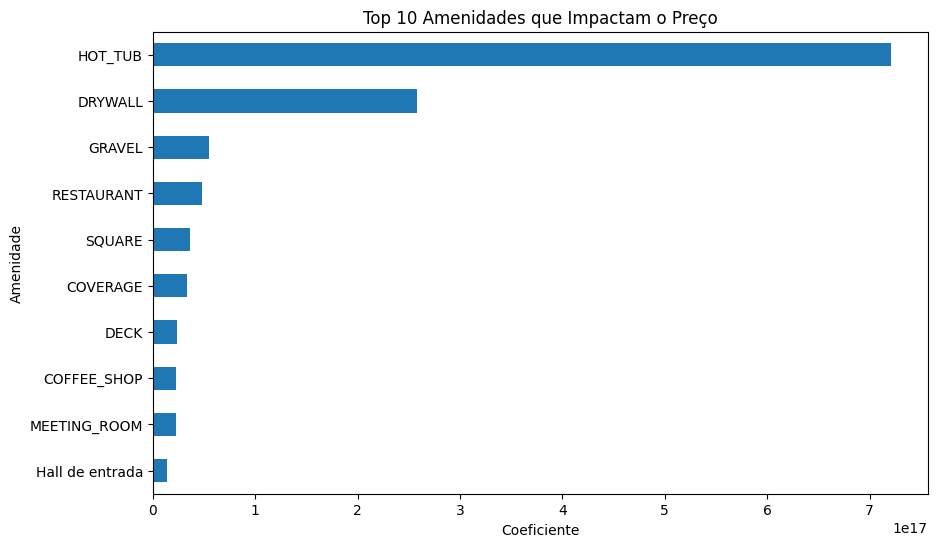

In [119]:
import matplotlib.pyplot as plt

# Selecionando as top 10 amenidades
top_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.xlabel('Coeficiente')
plt.ylabel('Amenidade')
plt.title('Top 10 Amenidades que Impactam o Preço')
plt.gca().invert_yaxis()
plt.show()


### Random Forest

In [134]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

temp = amenities_encoded.sample(10000)

# Preparação dos dados
X = temp.drop(columns=["price"])
y = temp["price"]

# Divisão em folds para validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicialização do modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Avaliação com validação cruzada
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

print(f"RMSE médio: {rmse_scores.mean()}")

# Treinamento no conjunto completo
model.fit(X, y)

# Extração das importâncias das features
feature_importance = pd.Series(model.feature_importances_, index=X.columns)

# Ordenando as features por importância
feature_importance = feature_importance.sort_values(ascending=False)

print("Importância das Features:")
print(feature_importance)


RMSE médio: 561225.7302399122
Importância das Features:
FIREPLACE                    0.199550
POOL                         0.083485
DINNER_ROOM                  0.058031
HOME_OFFICE                  0.049154
BACKYARD                     0.036620
                               ...   
Rede de água e esgoto        0.000000
Plano                        0.000000
Arenoso                      0.000000
FULL_CABLING                 0.000000
ESSENTIAL_PUBLIC_SERVICES    0.000000
Length: 248, dtype: float64


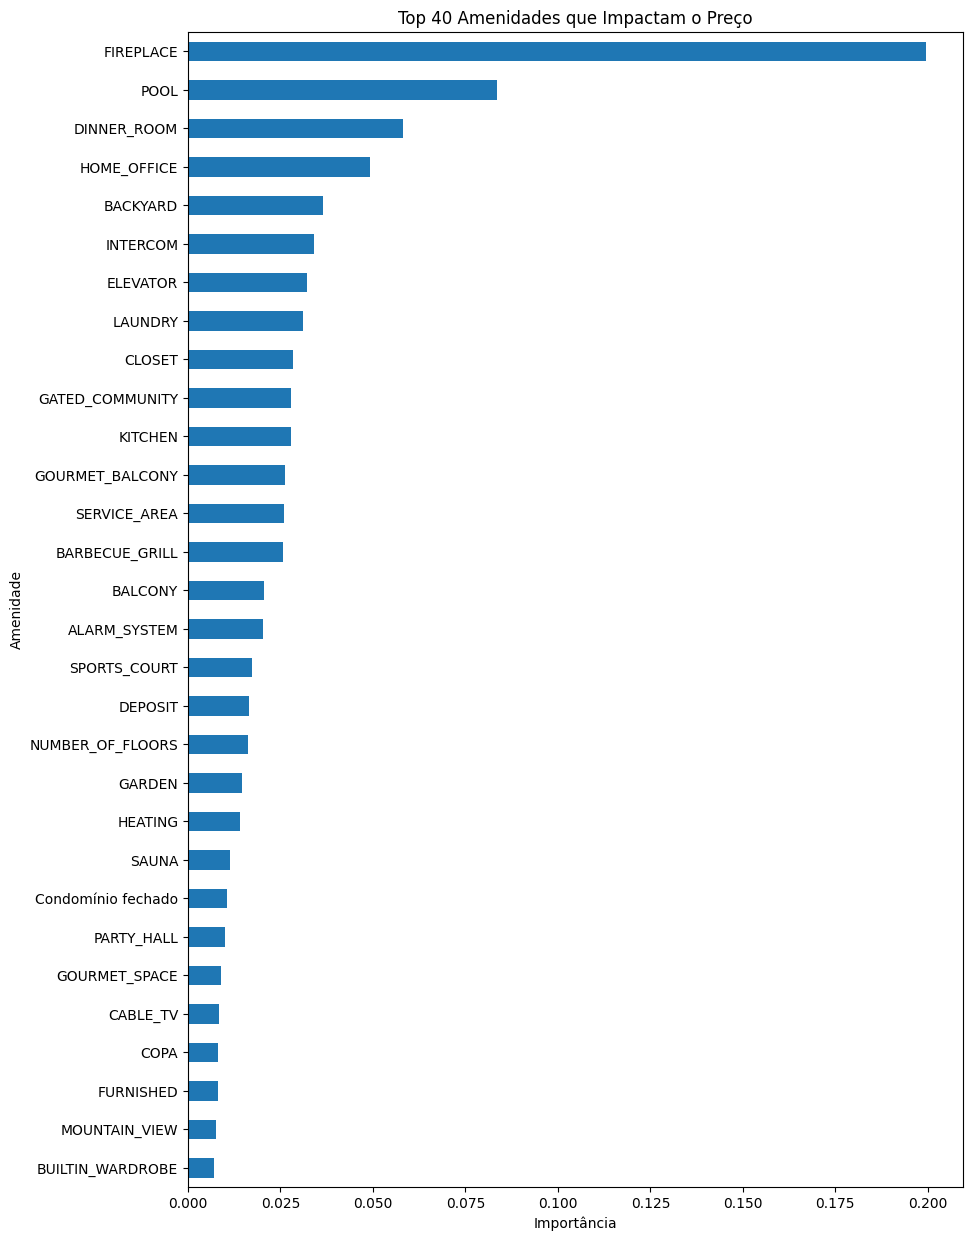

In [141]:
# Selecionando as top 10 amenidades
top_features = feature_importance.head(30)

plt.figure(figsize=(10, 15))
top_features.plot(kind='barh')
plt.xlabel('Importância')
plt.ylabel('Amenidade')
plt.title('Top 40 Amenidades que Impactam o Preço')
plt.gca().invert_yaxis()
plt.show()


In [145]:
list(top_features.index)

['FIREPLACE',
 'POOL',
 'DINNER_ROOM',
 'HOME_OFFICE',
 'BACKYARD',
 'INTERCOM',
 'ELEVATOR',
 'LAUNDRY',
 'CLOSET',
 'GATED_COMMUNITY',
 'KITCHEN',
 'GOURMET_BALCONY',
 'SERVICE_AREA',
 'BARBECUE_GRILL',
 'BALCONY',
 'ALARM_SYSTEM',
 'SPORTS_COURT',
 'DEPOSIT',
 'NUMBER_OF_FLOORS',
 'GARDEN',
 'HEATING',
 'SAUNA',
 'Condomínio fechado',
 'PARTY_HALL',
 'GOURMET_SPACE',
 'CABLE_TV',
 'COPA',
 'FURNISHED',
 'MOUNTAIN_VIEW',
 'BUILTIN_WARDROBE']

In [82]:
amenities_encoded

array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])                          ,
       array([0., 0., 0., 0., 0., 0., 0

In [79]:
list(amenities_encoded.iloc[0])

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

In [ ]:
tenho uma lista python `estate_amenities` e um numpy array unidimensional `relevant_amenities`.
Quero gerar um novo numpy array com a mesma dimensão que `relevant_amenities` mas que seja 0 caso o valor de `relevant_amenities`
não esteja contido em `estate_amenities` e 1 se estiver

In [55]:
estate_amenities = ['KITCHEN', 'BAR']
presence_array = 

print(presence_array)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [53]:
relevant_amenities

array(['KITCHEN', 'INTERCOM', 'SERVICE_AREA', '', 'BARBECUE_GRILL',
       'ELEVATOR', 'GATED_COMMUNITY', 'BALCONY', 'BACKYARD', 'POOL',
       'LAUNDRY', 'GOURMET_BALCONY', 'HOME_OFFICE', 'ALARM_SYSTEM',
       'GARDEN', 'GOURMET_SPACE', 'PARTY_HALL', 'CABLE_TV', 'DINNER_ROOM',
       'ADULT_GAME_ROOM', 'KITCHEN_CABINETS', 'DEPOSIT', 'SAUNA', 'GYM',
       'FIREPLACE', 'PETS_ALLOWED', 'CLOSET', 'AIR_CONDITIONING',
       'ELECTRONIC_GATE', 'PLAYGROUND', 'FURNISHED', 'RECEPTION', 'COPA',
       'MOUNTAIN_VIEW', 'SPORTS_COURT', 'SECURITY_24_HOURS', 'Cozinha',
       'GREEN_SPACE', 'HEATING', 'GARAGE', 'SAFETY_CIRCUIT',
       'AMERICAN_KITCHEN', 'CONCIERGE_24H', 'NEAR_HOSPITAL',
       'NEAR_SCHOOL', 'Churrasqueira', 'Interfone', 'BUILTIN_WARDROBE',
       'Área de serviço', 'SPA', 'Aceita animais', 'YOUTH_GAME_ROOM',
       'Quintal', 'GAMES_ROOM', 'NUMBER_OF_FLOORS', 'DISABLED_ACCESS',
       'SEA_VIEW', 'Elevador', 'Varanda', 'INTERNET_ACCESS', 'CINEMA',
       'INTEGRATED_ENVIRONMEN

In [49]:
amenities

,index,count
0,KITCHEN,25820
1,INTERCOM,24671
2,SERVICE_AREA,23413
3,,18833
4,BARBECUE_GRILL,15333
...,...,...
250,Desnível para frente (rua),1
251,REDARIO,1
252,NEAR_SHOPPING_CENTER_2,1
253,ELECTRIC_GENERATOR,1


In [24]:
[x for x in gss.split(df, groups=groups)]

TypeError: '<' not supported between instances of 'int' and 'str'

In [14]:
qte_imoveis_unicos = df["estate_id"].nunique()
print(f"qte_imoveis_unicos = {qte_imoveis_unicos}")

qte_imoveis_unicos = 21763


In [8]:
not_necessary_columns = [
    "id",
    "action",
    "post_type",
]

In [7]:
df

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu,price_m2
0,fc495ad4-19d8-46a5-a6a8-065e5258d52e,2635911061,venda,2024-11-27,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,Apartamento com 3 quartos à venda,NaN,Jardim dos Estados,Poços de Caldas,MG,-21.783975,-46.552999,235.0,3.0,1.0,2.0,"['Cozinha', 'Elevador', 'Interfone', 'Área de ...",800000.0,700.0,0.0,3404.255319
1,ff0af6b2-ef1b-4070-ae2f-0a6312c47157,2753629515,venda,2024-11-27,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,Casa com 4 quartos à venda,NaN,Boa Esperança,Poços de Caldas,MG,-21.826302,-46.557761,219.0,4.0,4.0,3.0,NaN,450000.0,NaN,NaN,2054.794521
2,02007133-c21e-4dc9-9e2f-34e9d95e92d6,2756849948,venda,2024-11-27,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,Casa com 3 quartos à venda,NaN,Jardim Carolina,Poços de Caldas,MG,-21.793090,-46.601182,131.0,3.0,4.0,3.0,"['Circuito de segurança', 'Portaria 24h', 'Esp...",820000.0,NaN,NaN,6259.541985
3,476271bb-6912-4e8f-acdb-f9389ab87124,2635633461,venda,2024-11-27,PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,Casa com quarto à venda,NaN,Jardim Ipê,Poços de Caldas,MG,-21.802998,-46.543752,63.0,1.0,1.0,NaN,NaN,250000.0,NaN,NaN,3968.253968
4,2277df07-4a44-4526-b8a7-bce42e1b5298,2731635351,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,Apartamento com 2 quartos à venda,NaN,Jardim Bandeirantes,Poços de Caldas,MG,-21.809666,-46.586492,50.0,2.0,1.0,1.0,"['Cozinha', 'Interfone', 'Varanda', 'Área de s...",200000.0,180.0,660.0,4000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101086,81988932-594c-442d-b785-6a9f3a63ae83,2721270711,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-gal...,Rural,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Parque Pinheiros, Poços de Caldas",NaN,Parque Pinheiros,Poços de Caldas,NaN,-21.809625,-46.498703,264.0,NaN,1.0,2.0,NaN,400000.0,NaN,NaN,1515.151515
101087,53582db5-40ef-4e61-bf47-1ad12af6424f,2737831038,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Jardim Vitória V, Poços de Caldas",NaN,Jardim Vitória V,Poços de Caldas,NaN,-21.802387,-46.571022,85.0,3.0,1.0,1.0,NaN,400000.0,NaN,NaN,4705.882353
101088,7fe1b698-cca7-4e42-9d99-2fbaa528e244,2646975845,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Jardim das Hortênsias, Poços de Caldas",NaN,Jardim das Hortênsias,Poços de Caldas,NaN,-21.804587,-46.542271,240.0,2.0,1.0,3.0,NaN,1200000.0,0.0,1.0,5000.000000
101089,adbab17b-2a79-4268-b0df-543ef85cbbc7,2742057854,venda,2024-11-30,STANDARD,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,['https://resizedimgs.zapimoveis.com.br/crop/6...,"Centro, Poços de Caldas",NaN,Centro,Poços de Caldas,NaN,-21.784097,-46.570472,55.0,1.0,1.0,1.0,NaN,450000.0,360.0,605.0,8181.818182
